# Solving TSP problem using Genetic Algorithm
The goal is to find the shortest route that visits each city exactly once and returns to the starting point.

# import needed libraries

In [1206]:
import pandas as pd  # data processing and CSV file I/O
import numpy as np  # linear algebra and array operations
import math  # mathematical calculations, such as distance calculations
import itertools  # creating iterators for efficient looping and combination generation
import random  # generating random numbers and shuffling data
import matplotlib.pyplot as plt  # plotting graphs and visualizations
import copy  # deep copy operations

# Read Data
dataset_link: https://drive.google.com/file/d/16-TTRrrDjE1Lbu30xfM67nJguzvWgyUA/view?usp=sharing

the dataset contains 15 points, and each point has X-Y coordinates.

In [1207]:
class City:
    """
    A class to represent a city in the Traveling Salesman Problem (TSP).

    Attributes:
        name (str): The name of the city.
        lat (float): The latitude coordinate of the city.
        long (float): The longitude coordinate of the city.
    """

    def __init__(self, name, lat, long):
        """
        Initializes a City object with the given name, latitude, and longitude.

        Args:
            name (str): The name of the city.
            lat (float): The latitude coordinate of the city.
            long (float): The longitude coordinate of the city.
        """
        self.name = name
        self.lat = float(lat)
        self.long = float(long)

    def __str__(self):
        """
        Returns a string representation of the City object.

        Returns:
            str: A string containing the name, latitude, and longitude of the city.
        """
        return f"City: {self.name}, lat: {self.lat}, long: {self.long}"


In [1208]:
def get_all_cities(file_path):
    """
    Reads cities data from a CSV file and creates City objects for each city.

    Args:
        file_path (str): The path to the CSV file containing cities data.

    Returns:
        list: A list of City objects representing all cities read from the CSV file.
    """
    all_cities = []  # Initialize an empty list to store City objects
    df = pd.read_csv(file_path)  # Read the CSV file into a pandas DataFrame
    for i in range(df.shape[0]):
        # Iterate through each row in the DataFrame and create a City object for each city
        city = City(df.iloc[i]['City'], df.iloc[i]['x'], df.iloc[i]['y'])
        all_cities.append(city)  # Add the City object to the list
    return all_cities

In [1209]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1210]:
data_path = '/content/drive/MyDrive/TSP_dataset.csv'
all_cities = get_all_cities(data_path)

print("Printing all cities:")
for city in all_cities:
    print(city)

Printing all cities:
City: 1.0, lat: 5.5e-08, long: 9.86e-09
City: 2.0, lat: -28.8733, long: -7.98e-08
City: 3.0, lat: -79.2916, long: -21.4033
City: 4.0, lat: -14.6577, long: -43.3896
City: 5.0, lat: -64.7473, long: 21.8982
City: 6.0, lat: -29.0585, long: -43.2167
City: 7.0, lat: -72.0785, long: 0.181581
City: 8.0, lat: -36.0366, long: -21.6135
City: 9.0, lat: -50.4808, long: 7.37447
City: 10.0, lat: -50.5859, long: -21.5882
City: 11.0, lat: -0.135819, long: -28.7293
City: 12.0, lat: -65.0866, long: -36.0625
City: 13.0, lat: -21.4983, long: 7.31942
City: 14.0, lat: -57.5687, long: -43.2506
City: 15.0, lat: -43.07, long: 14.5548


# generate distance matrix

In [1211]:
def calculate_distance(city1, city2):
    """
    Calculates the Euclidean distance between two cities.

    Args:
        city1 (City): The first city.
        city2 (City): The second city.

    Returns:
        float: The Euclidean distance between the two cities.
    """
    p = [city1.lat, city1.long]  # Coordinates of city1
    q = [city2.lat, city2.long]  # Coordinates of city2
    return math.dist(p, q)  # Calculate the Euclidean distance using math.dist


# This function will be run once at the beginning of the program to create a distance matrix
def generate_distance_matrix(all_cities):
    """
    Generates a distance matrix based on the Euclidean distances between cities.

    Args:
        all_cities (list): A list of City objects representing all cities.

    Returns:
        np.ndarray: A 2D NumPy array representing the distance matrix between cities.
    """
    num_cities = len(all_cities)
    matrix = np.zeros((num_cities, num_cities))  # Initialize a NumPy array filled with zeros
    # Iterate through each pair of cities to calculate the distance
    for i in range(num_cities):
        for j in range(num_cities):
            # Calculate the distance between city i and city j using the calculate_distance function
            matrix[i, j] = calculate_distance(all_cities[i], all_cities[j])
    return matrix

In [1212]:
distance_matrix=generate_distance_matrix(all_cities)

# intialize genetic algorithm parameters

In [1213]:
# Genetic algorithm parameters
population_size = 50  # The number of chromosomes (solutions) in each generation
generations_count = 150  # The total number of generations the genetic algorithm will run for
elitism_percentage = 0.02  # The percentage of the population preserved through elitism (the best-performing individuals)
                           # In this case, it's 2% of the population
crossover_probability = 0.6  # The probability that crossover (recombination) will occur between two parent chromosomes during reproduction
mutation_probability = 0.1  # The probability that a mutation will occur in a chromosome during reproduction

# generate initial population

In [1214]:
class Chromosome:
    """
    A class to represent a chromosome (solution) in the Genetic Algorithm.

    Attributes:
        cities (list): A list of City objects representing genes in the chromosome.
        fitness (float): The fitness value of the chromosome.
        cost (float): The cost (total distance) of the chromosome's tour.
    """

    def __init__(self, cities):
        """
        Initializes a Chromosome object with the given cities, fitness, and cost.

        Args:
            cities (list): A list of City objects representing genes in the chromosome.
        """
        self.cities = cities
        self.fitness = 0.0
        self.cost = 0.0


    def calculate_cost(self, distance_matrix):
        """
        Calculates the total distance (cost) of the chromosome's tour.

        Args:
            distance_matrix (numpy.ndarray): The distance matrix between cities.

        Returns:
            float: The total distance (cost) of the chromosome's tour.
        """

        total_distance = 0  # Initialize the total distance to zero

        first = self.cities[0]  # Get the first city
        second = self.cities[1]  # Get the second city

        # Add the distance between the first and second cities to the total distance
        total_distance += distance_matrix[int(first.name) - 1, int(second.name) - 1]

        # Iterate through the ramaining chromosome's cities and add distances
        for i in range(1,len(self.cities)-1):
          total_distance += distance_matrix[int(self.cities[i].name) - 1, int(self.cities[i+1].name) - 1]

        return total_distance

    def evaluate_fitness(self):
        """
        Evaluates the fitness of a chromosome.

        Returns:
            float: The fitness value of the chromosome.
        """
        # The fitness is inversely proportional to the cost
        # Higher fitness for lower cost (shorter tour)
        return 1 / self.cost

    def __str__(self):
        """
        Returns a string representation of the Chromosome object.

        Returns:
            str: A string containing the city names, fitness, and cost of the chromosome.
        """
        city_names = ', '.join(city.name for city in self.cities)
        return f"Chromosome_Cities: {city_names}, fitness: {self.fitness}, cost: {self.cost}"


In [1215]:
def generate_initial_population(all_cities, distance_matrix, population_size):
    """
    Generates the initial population of chromosomes.

    Args:
        all_cities (list): A list of City objects representing all cities.
        distance_matrix (numpy.ndarray): The distance matrix between cities.
        population_size (int): The desired size of the initial population.

    Returns:
        list: A list of Chromosome objects representing the initial population.
    """

    initial_population = []  # Initialize an empty list to store the initial population

    for i in range(population_size):
        #create random path using permutations
        cities=np.random.permutation(all_cities)
        ch = Chromosome(cities)  # Create a chromosome with the given cities
        # Calculate the cost and fitness of the chromosome based on the distance matrix
        ch.cost = ch.calculate_cost(distance_matrix)
        ch.fitness = ch.evaluate_fitness()
        initial_population.append(ch)  # Add the chromosome to the initial population
    return initial_population

In [1216]:
initial_population=generate_initial_population(all_cities,distance_matrix,population_size)

In [1217]:
#add the initial population to the genration list
generations=[]
generations.append(initial_population)

#Genetic Algorithm

In [1218]:
def elitism(population, elitism_percentage):
    """
    Selects the best chromosomes from a population based on their fitness scores using elitism.

    Args:
    - population (list): A list of chromosomes representing the population.
    - elitism_percentage (float): The percentage of the population to be selected as elite.

    Returns:
    - best_chromosomes (list): A list of the best chromosomes based on their fitness scores.
    """

    # Calculate the number of chromosomes to be selected as elite
    elitism_count = int(elitism_percentage * len(population))

    # Sort the population based on fitness in descending order
    sorted_population = sorted(population, key=lambda x: x.fitness, reverse=True)

    # Select the elite chromosomes
    best_chromosomes = sorted_population[:elitism_count]

    return best_chromosomes

In [1219]:
def selection(population, candidates_num):
    """
    Performs tournament selection to choose the best candidate from a subset of the population (based on candidates_num).

    Args:
    - population (list): A list of chromosomes representing the population.
    - candidates_num (int): The number of candidates to consider in each tournament.

    Returns:
    - best_candidate: The best candidate selected from the tournament.
    """
    # Randomly sample candidates from the population
    candidates = random.sample(population, candidates_num)

    # Sort the candidates based on fitness in descending order
    sorted_candidates = sorted(candidates, key=lambda x: x.fitness, reverse=True)

    # Select the best candidate from the sorted candidates
    best_candidate = sorted_candidates[0]

    return best_candidate

In [1220]:
def find_alternative(item, child, other_child, start_index, end_index):
    """
    Finds an alternative item from the other parent within the specified indexes.

    Args:
    - item: The item to find an alternative for.
    - child (list): The child chromosome being modified.
    - other_child (list): The other parent's child chromosome.
    - start_index (int): Start index for the search.
    - end_index (int): End index for the search.

    Returns:
    - alternative_item: The alternative item found from the other parent.
    """
    # Extract names of elite cities
    names=[]
    for i in range(start_index,end_index):
      names.append(child[i].name)

    while True:
        # Check if the item is within the specified indexes of the child
        if item.name in names:
            idx = names.index(item.name)
            # Get the alternative item from the corresponding position in the other parent's child
            item = other_child[start_index+idx]
        else:
            break
    return item

def crossover(parent1, parent2, elitism_count):
    """
    Performs partially mapped crossover (PMX) between two parent chromosomes.

    Args:
    - parent1 (list): First parent chromosome.
    - parent2 (list): Second parent chromosome.
    - population_size (int): Total population size.
    - elitism_count (int): Number of elite chromosomes.

    Returns:
    - child1 (list): First child chromosome resulting from crossover.
    - child2 (list): Second child chromosome resulting from crossover.
    """
    # Calculate crossover points based on population size and elitism count
    remaining_size = len(parent1.cities) - elitism_count
    crossover_point1 = math.ceil(remaining_size / 2)
    crossover_point2 = len(parent1.cities) - (remaining_size - crossover_point1)

    child1_cities = list(np.zeros(len(parent1.cities)))
    child2_cities = list(np.zeros(len(parent2.cities)))
    # Perform crossover within the specified crossover points
    child1_cities[crossover_point1:crossover_point2] = parent2.cities[crossover_point1:crossover_point2]
    child2_cities[crossover_point1:crossover_point2] = parent1.cities[crossover_point1:crossover_point2]

    # Resolve conflicts in the remaining sections using find_alternative
    for i in range(crossover_point1):
        # Resolve conflicts in the first section of the child chromosomes
        child1_cities[i] = find_alternative(parent1.cities[i], child1_cities, child2_cities, crossover_point1, crossover_point2)
        child2_cities[i] = find_alternative(parent2.cities[i], child2_cities, child1_cities, crossover_point1, crossover_point2)

    for i in range(crossover_point2, len(parent1.cities)):
        # Resolve conflicts in the second section of the child chromosomes
        child1_cities[i] = find_alternative(parent1.cities[i], child1_cities, child2_cities, crossover_point1, crossover_point2)
        child2_cities[i] = find_alternative(parent2.cities[i], child2_cities, child1_cities, crossover_point1, crossover_point2)

    child1 = Chromosome(child1_cities)  # Create a chromosome with the given cities
    # Calculate the cost and fitness of the chromosome based on the distance matrix
    child1.cost = child1.calculate_cost(distance_matrix)
    child1.fitness = child1.evaluate_fitness()

    child2 = Chromosome(child2_cities)  # Create a chromosome with the given cities
    # Calculate the cost and fitness of the chromosome based on the distance matrix
    child2.cost = child2.calculate_cost(distance_matrix)
    child2.fitness = child2.evaluate_fitness()

    # Evaluate the new children (better than parents or not)
    if child1.fitness>=parent1.fitness and child2.fitness>=parent2.fitness:
      return child1, child2
    else:
      return parent1, parent2

In [1221]:
def mutation(chromosome):
    """
    Performs mutation by swapping two nodes of the chromosome.

    Args:
    - chromosome (list): The chromosome to be mutated.

    Returns:
    - mutated_chromosome (list): The mutated chromosome after swapping nodes.
    """

    # Randomly select two indexes for mutation
    mutation_index_1, mutation_index_2 = random.sample(range(len(chromosome.cities)), 2)

    # Swap the nodes at the mutation indexes
    chromosome.cities[mutation_index_1], chromosome.cities[mutation_index_2] = chromosome.cities[mutation_index_2], chromosome.cities[mutation_index_1]

    # Calculate the cost and fitness of the chromosome based on the distance matrix
    chromosome.cost = chromosome.calculate_cost(distance_matrix)
    chromosome.fitness = chromosome.evaluate_fitness()

    return chromosome


In [1222]:
def create_new_generation(previous_generation, elitism_percentage, crossover_probability, mutation_probability, population_size):
    """
    Creates a new generation of chromosomes using elitism, crossover, and mutation operators.

    Args:
    - previous_generation (list): The previous generation of chromosomes.
    - elitism_percentage (float): The percentage of elite chromosomes to keep unchanged.
    - crossover_probability (float): The probability of crossover operation occurring.
    - mutation_probability (float): The probability of mutation operation occurring.
    - population_size (int): The total population size.

    Returns:
    - new_generation (list): The new generation of chromosomes.
    """
    # Keep the best chromosomes from the previous generation using elitism
    best_chromosomes = elitism(previous_generation, elitism_percentage)

    # Initialize the new generation with the best chromosomes
    new_generation = best_chromosomes

    # Iterate to create new chromosomes through crossover and mutation
    remaining =int(population_size-len(best_chromosomes))
    for a in range(remaining/2):
        # Selection: Choose parents for crossover
        candidates = 4
        parent1 = selection(previous_generation, candidates)
        parent2 = selection(previous_generation, candidates)

        # Crossover: Perform crossover if probability condition is met
        if random.uniform(0, 1) < crossover_probability:
            child_1, child_2 = crossover(parent1, parent2, elitism_count=int(elitism_percentage * population_size))
        else:
            child_1=parent1
            child_2=parent2

        # Mutation: Perform mutation if probability condition is met
        if random.uniform(0, 1) < mutation_probability:
            mutated = mutation(child_1)
            child_1 = mutated

        # Add new children to the new generation
        new_generation.append(child_1)
        new_generation.append(child_2)

    return new_generation

In [1223]:
def draw_path(solution):
    """
    Draws a path connecting cities in the solution on a scatter plot.

    Args:
    - solution: A solution object containing cities with latitude and longitude information.

    Returns:
    - None
    """
    # Initialize lists to store x and y coordinates
    x_list = []
    y_list = []


    # Extract latitude and longitude for each city in the solution
    for m in range(len(solution.cities)):
        x_list.append(solution.cities[m].lat)
        y_list.append(solution.cities[m].long)

    # Append the first point again
    x_list.append(solution.cities[0].lat)
    y_list.append(solution.cities[0].long)

    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Scatter plot the cities based on their coordinates
    plt.scatter(x_list, y_list)

    # Connect the cities in the order they appear in the solution
    ax.plot(x_list, y_list)

    # Display the plot
    plt.show()

In [1224]:
def genetic_algorithm(population_size, generations_count, elitism_percentage, crossover_probability, mutation_probability):
    """
    Executes the genetic algorithm for a specified number of generations.

    Args:
    - population_size (int): The size of each generation's population.
    - generations_count (int): The total number of generations to run.
    - elitism_percentage (float): The percentage of elite chromosomes to keep unchanged.
    - crossover_probability (float): The probability of crossover operation occurring.
    - mutation_probability (float): The probability of mutation operation occurring.

    Returns:
    - final_generation (list): The final generation of chromosomes.
    - costs_for_plot (list): The costs of the best chromosome in each generation for plotting.
    """
    new_gen = generations[-1]  # Start with the initial generation

    costs_for_plot = []  # List to store costs for plotting

    for iteration in range(generations_count):
        new_gen = create_new_generation(new_gen, elitism_percentage, crossover_probability, mutation_probability, population_size)

        # Print the cost of the best chromosome in each generation
        best_solution = selection(new_gen, 4)

        # Add the cost back to the first point to the cost list for plotting
        best_solution.cost += distance_matrix[int(best_solution.cities[-1].name) - 1, int(best_solution.cities[0].name) - 1]
        print(str(iteration) + ". generation --> " +"cost --> " + str(best_solution.cost))

        # Append the cost of the best chromosome to the list for plotting
        costs_for_plot.append(best_solution.cost)

        # Plot the best solution path for visualization
        draw_path(best_solution)

    return new_gen, costs_for_plot

In [1225]:
def draw_cost_generation(y_list):
    """
    Draws a line plot showing the cost of the best chromosome through generations.

    Args:
    - y_list (list): List of costs of the best chromosome in each generation.

    Returns:
    - None
    """
    x_list = np.arange(1, len(y_list) + 1)  # Create a numpy array from 1 to the number of generations

    plt.plot(x_list, y_list)  # Plot the costs against generations

    # Add title and labels to the plot
    plt.title("Route Cost through Generations")
    plt.xlabel("Generations")
    plt.ylabel("Cost")

    plt.show()  # Display the plot

0. generation --> cost --> 582.1812776276764


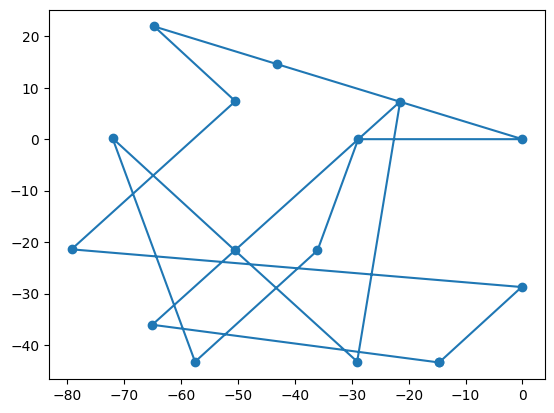

1. generation --> cost --> 555.0228034503864


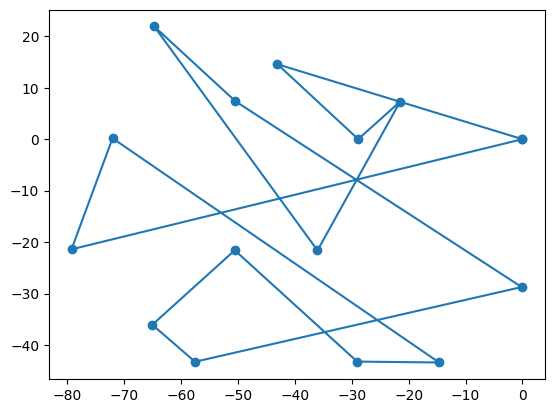

2. generation --> cost --> 504.6475012638117


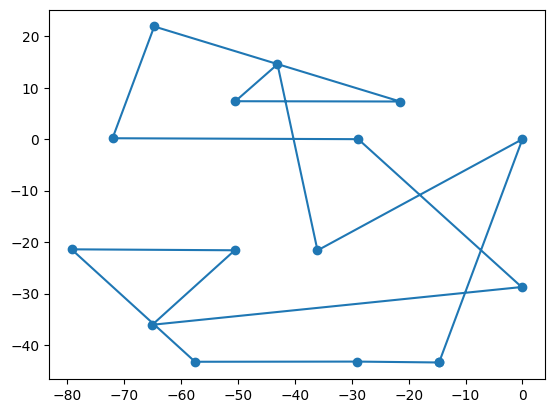

3. generation --> cost --> 517.0593580221241


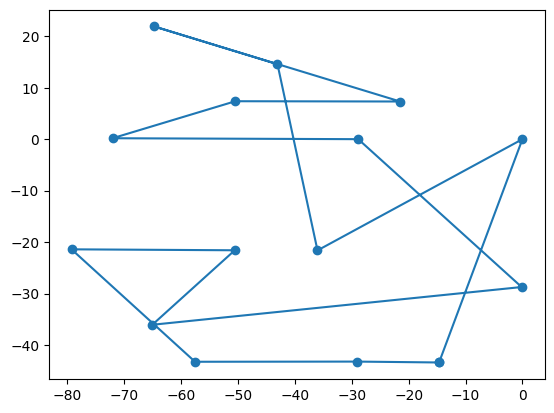

4. generation --> cost --> 504.6475012638117


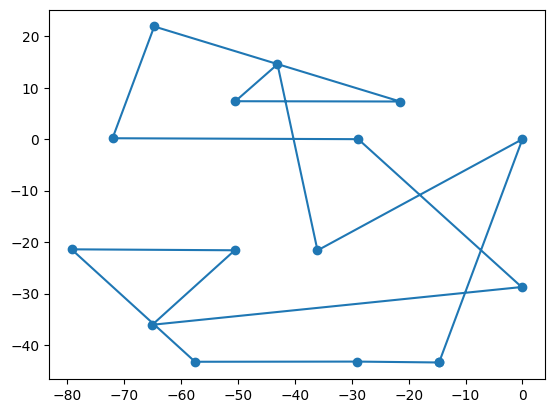

5. generation --> cost --> 498.6209009423286


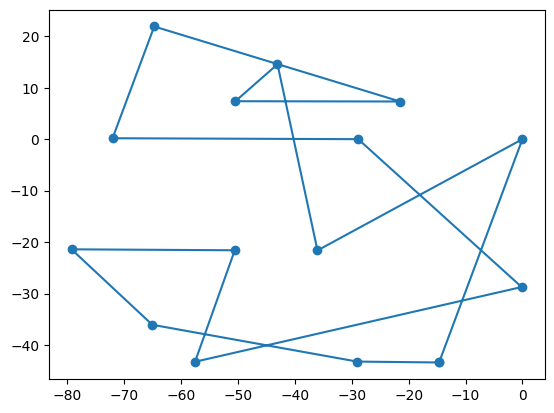

6. generation --> cost --> 498.6209009423286


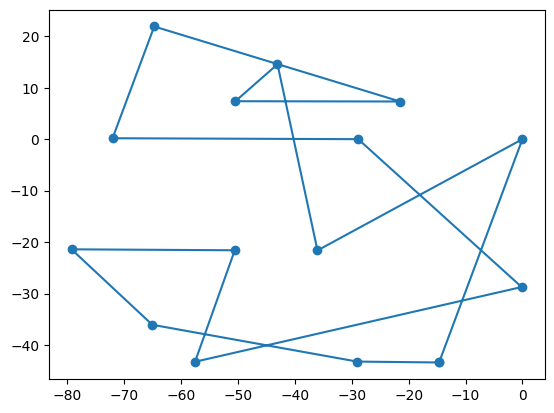

7. generation --> cost --> 498.6209009423286


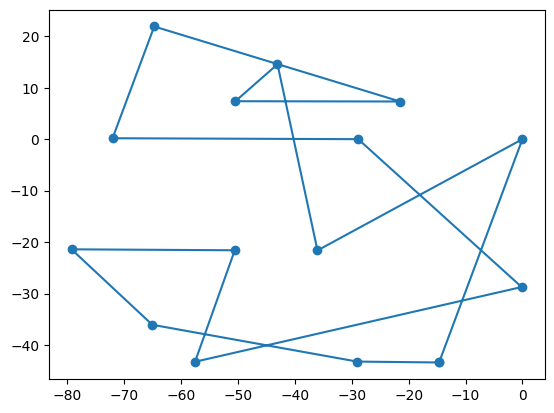

8. generation --> cost --> 462.8691335812207


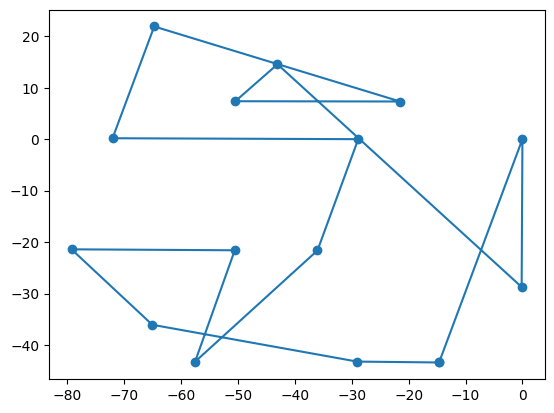

9. generation --> cost --> 462.8691335812207


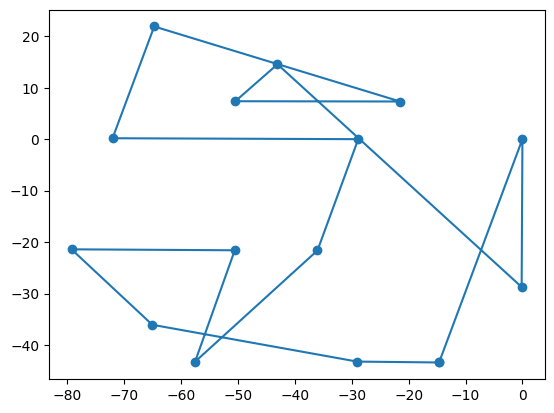

10. generation --> cost --> 508.6676658712187


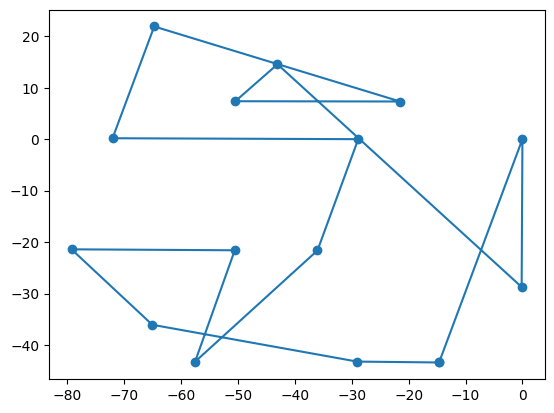

11. generation --> cost --> 462.8691335812207


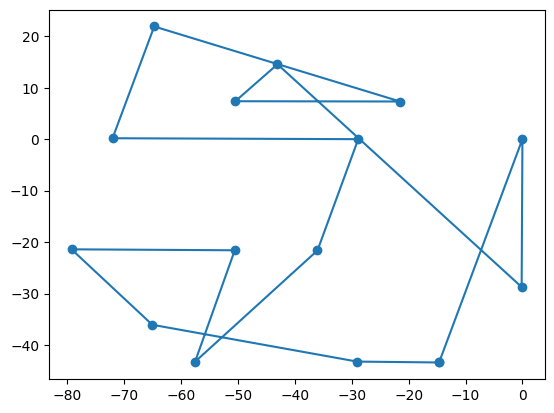

12. generation --> cost --> 462.8691335812207


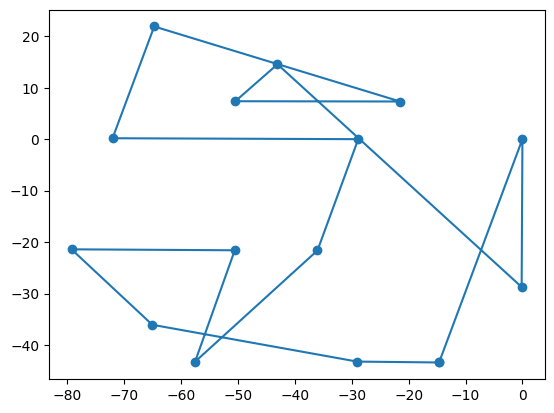

13. generation --> cost --> 462.8691335812207


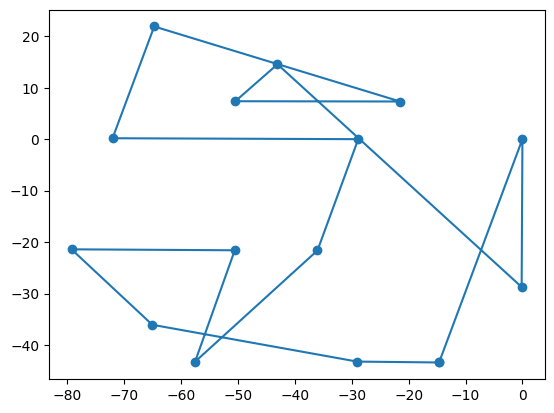

14. generation --> cost --> 462.8691335812207


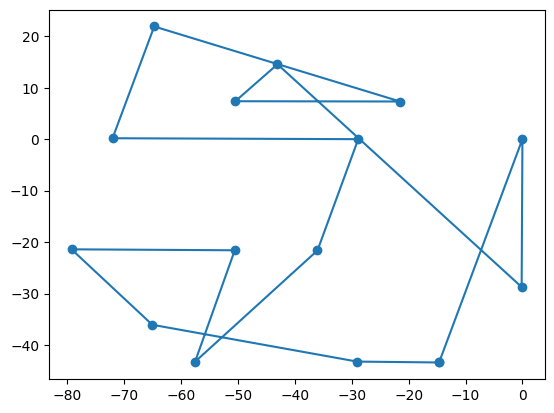

15. generation --> cost --> 462.8691335812207


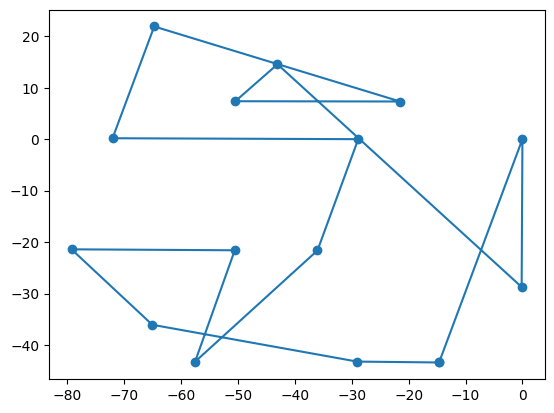

16. generation --> cost --> 462.8691335812207


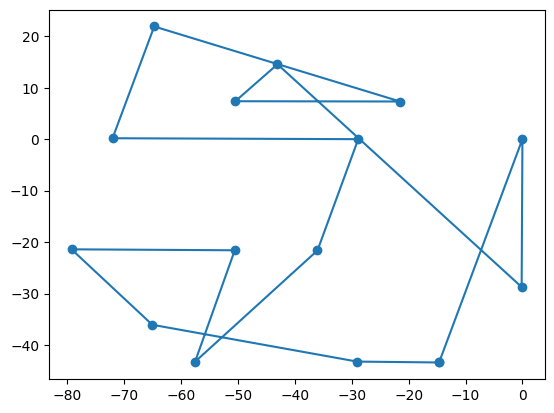

17. generation --> cost --> 462.8691335812207


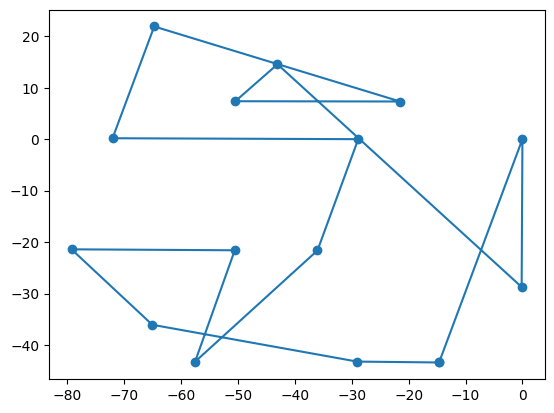

18. generation --> cost --> 444.29479420442465


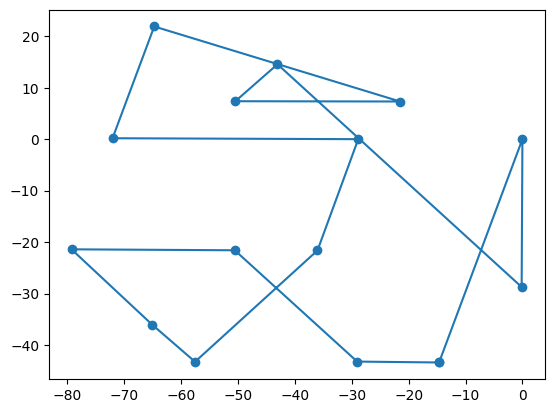

19. generation --> cost --> 448.9957451938576


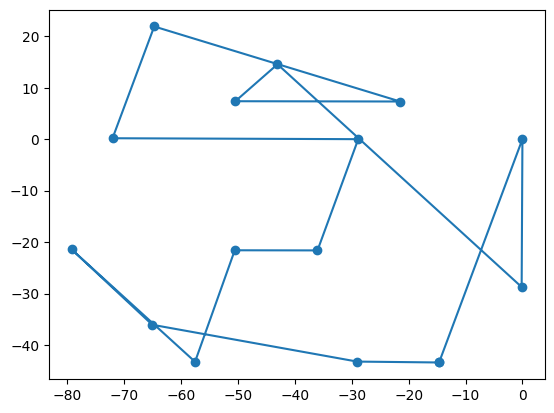

20. generation --> cost --> 443.4664185143828


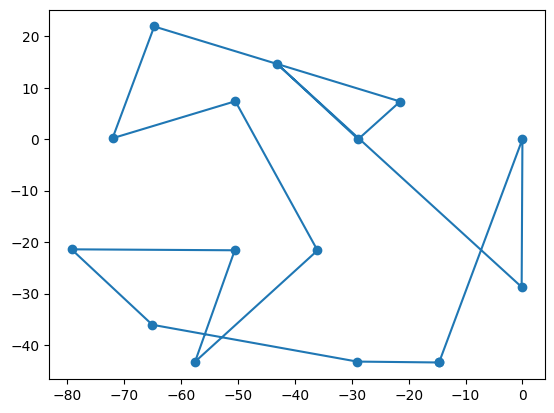

21. generation --> cost --> 443.4664185143828


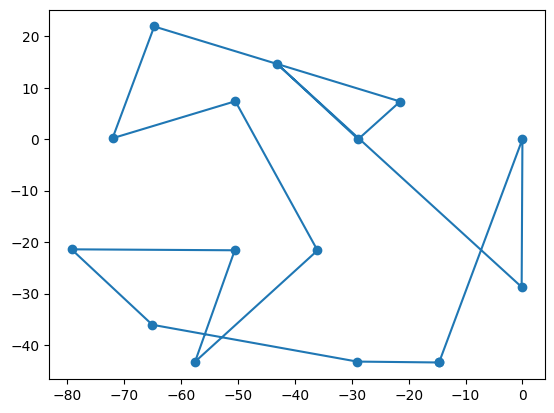

22. generation --> cost --> 444.29479420442465


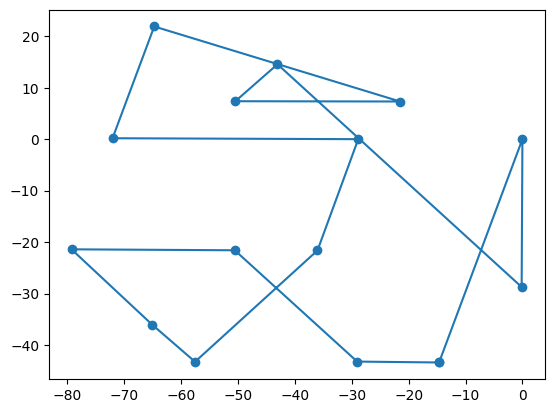

23. generation --> cost --> 443.4664185143828


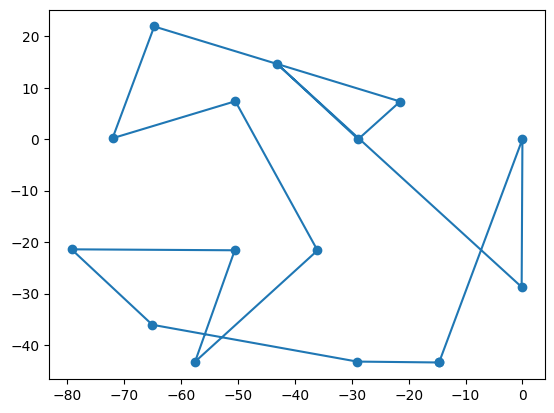

24. generation --> cost --> 402.47908576674945


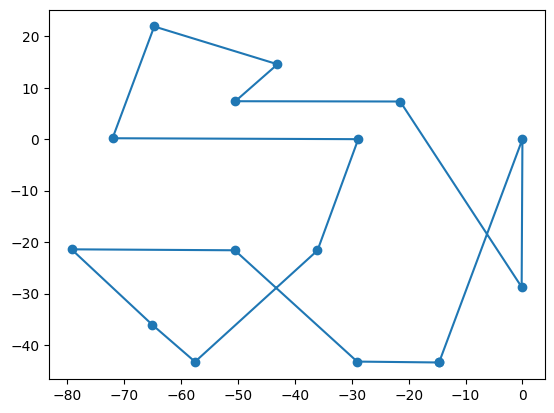

25. generation --> cost --> 429.2843973205843


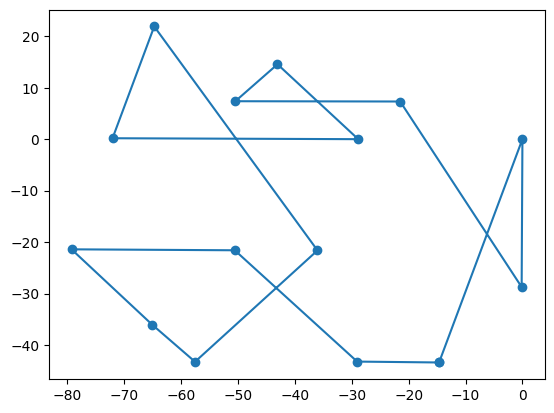

26. generation --> cost --> 429.2843973205843


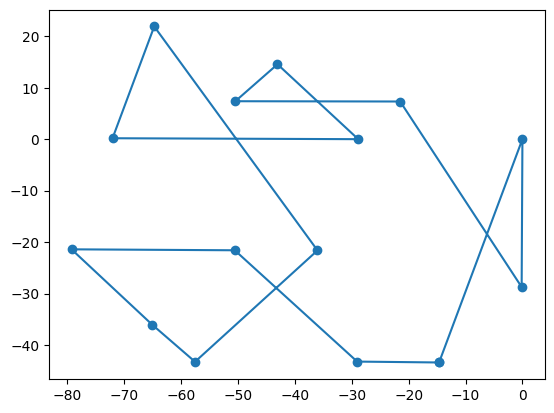

27. generation --> cost --> 429.2843973205843


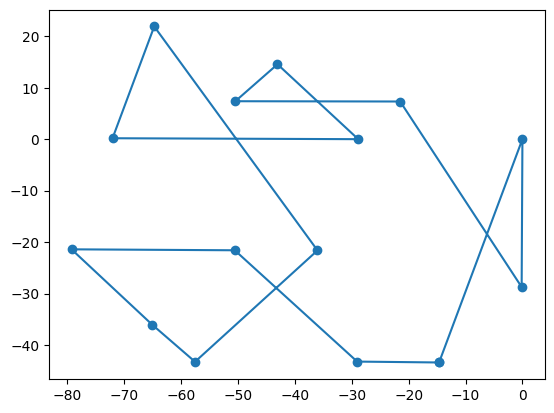

28. generation --> cost --> 429.2843973205843


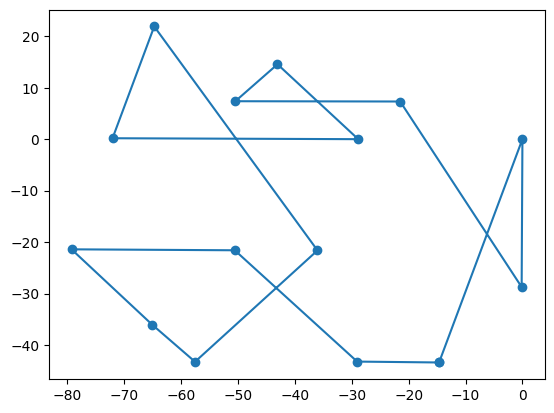

29. generation --> cost --> 429.2843973205843


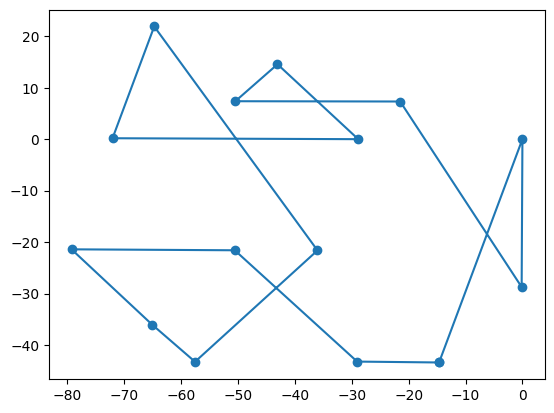

30. generation --> cost --> 429.2843973205843


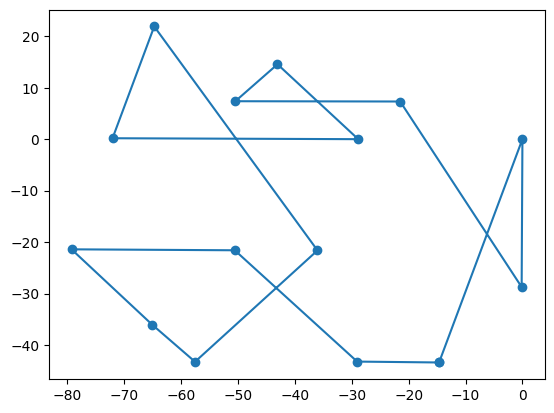

31. generation --> cost --> 429.2843973205843


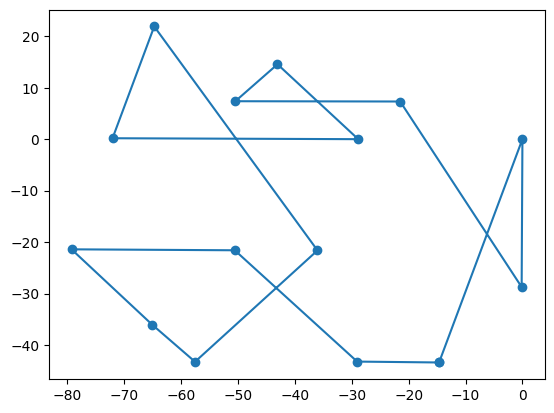

32. generation --> cost --> 429.2843973205843


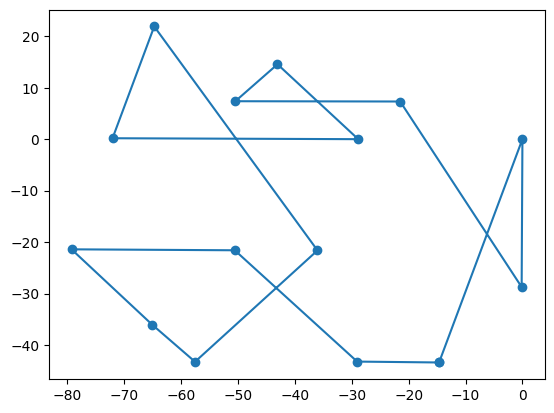

33. generation --> cost --> 429.2843973205843


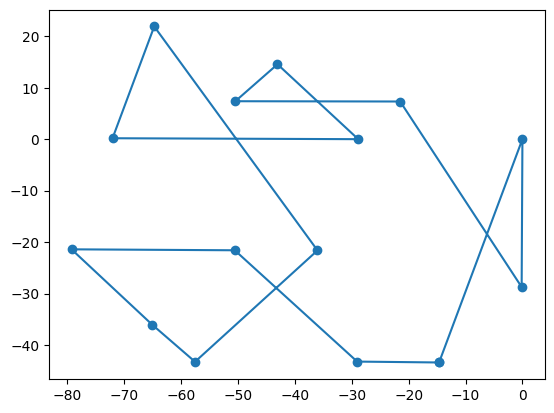

34. generation --> cost --> 429.2843973205843


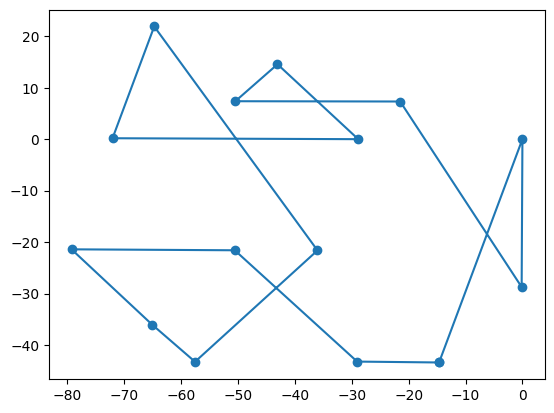

35. generation --> cost --> 421.8584641993866


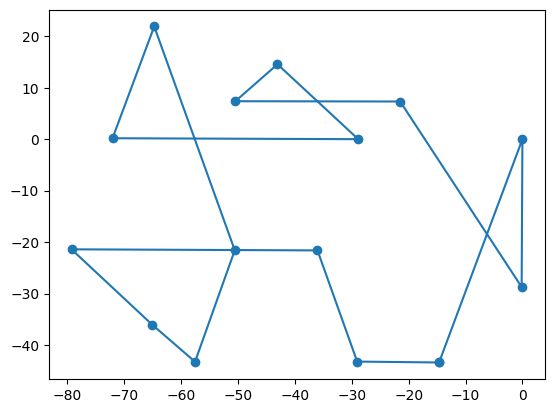

36. generation --> cost --> 421.8584641993866


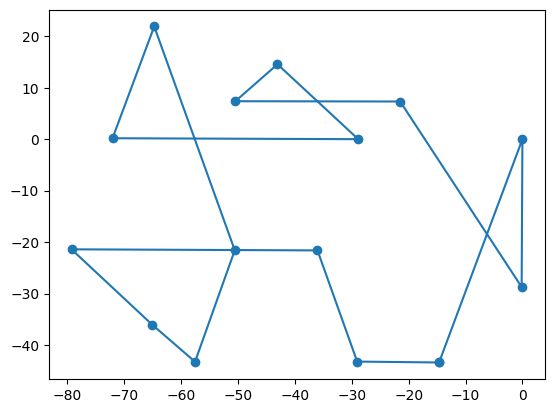

37. generation --> cost --> 421.8584641993866


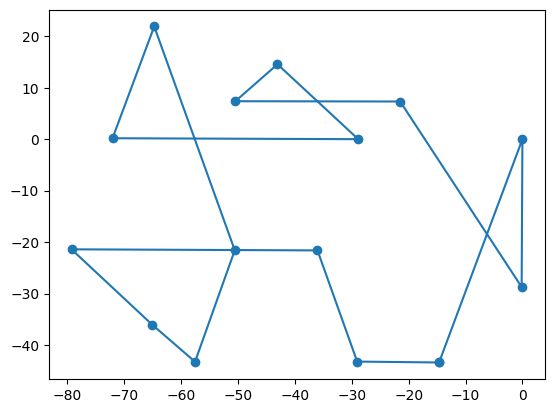

38. generation --> cost --> 421.8584641993866


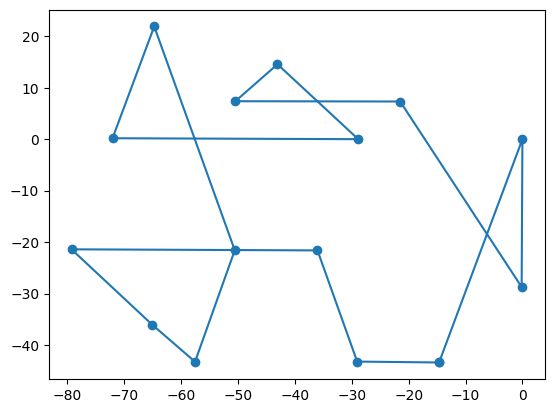

39. generation --> cost --> 421.8584641993866


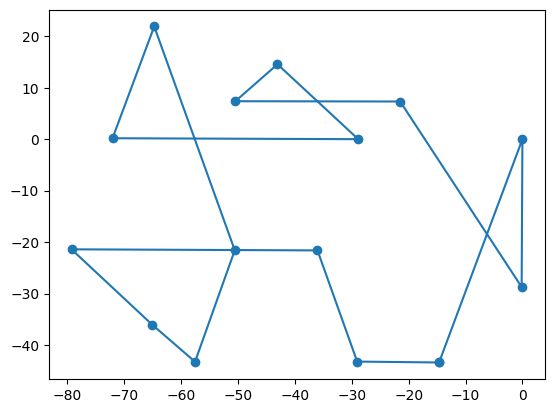

40. generation --> cost --> 421.8584641993866


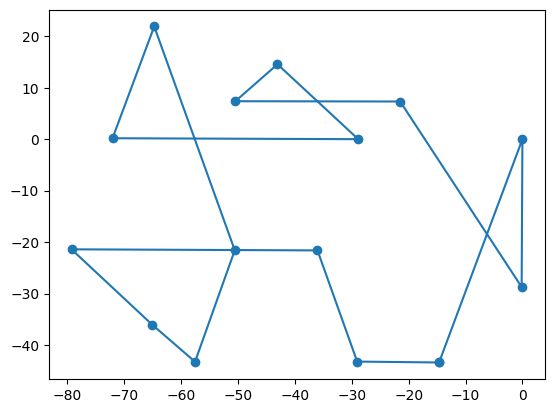

41. generation --> cost --> 421.8584641993866


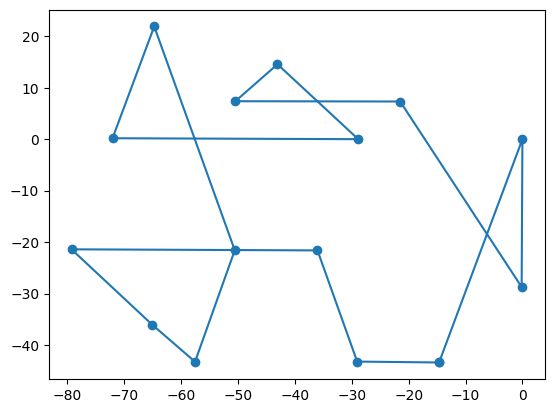

42. generation --> cost --> 421.8584641993866


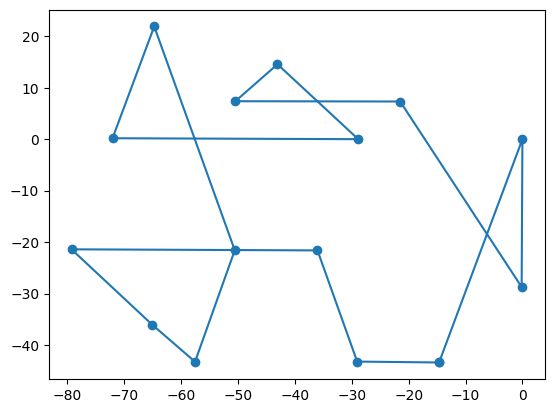

43. generation --> cost --> 421.8584641993866


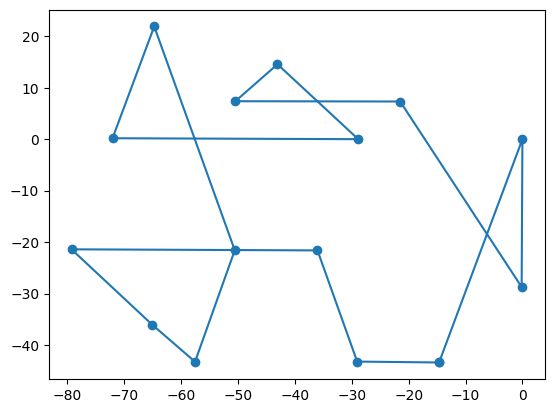

44. generation --> cost --> 421.8584641993866


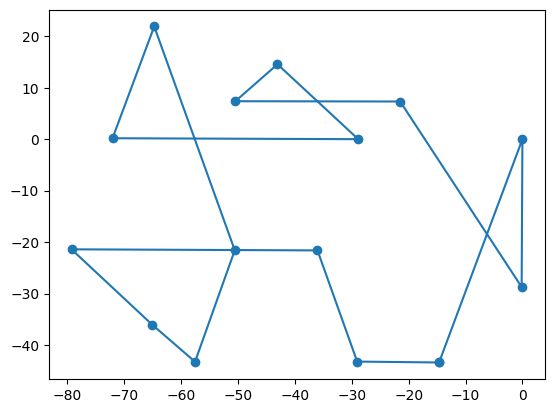

45. generation --> cost --> 409.298126440949


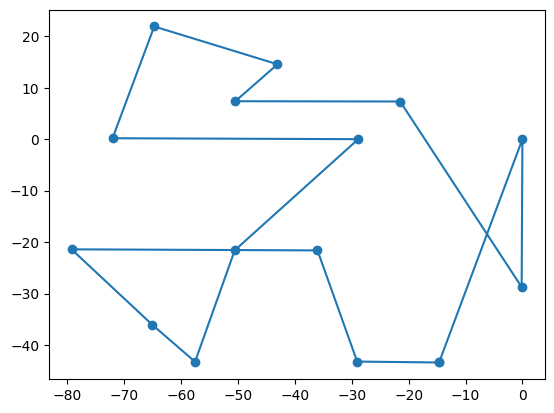

46. generation --> cost --> 409.298126440949


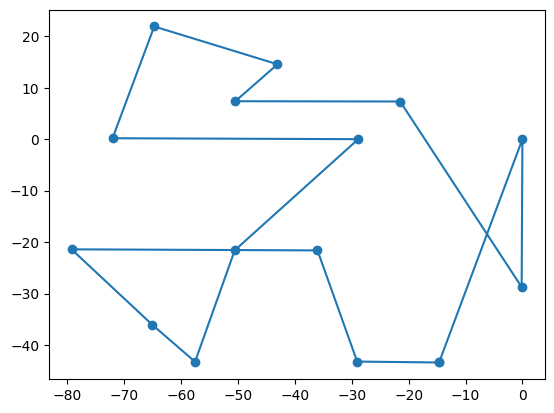

47. generation --> cost --> 409.298126440949


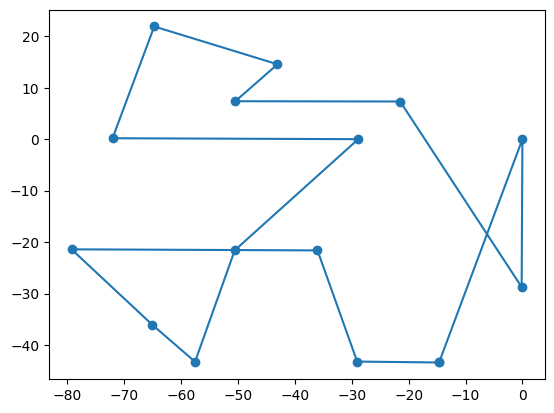

48. generation --> cost --> 409.298126440949


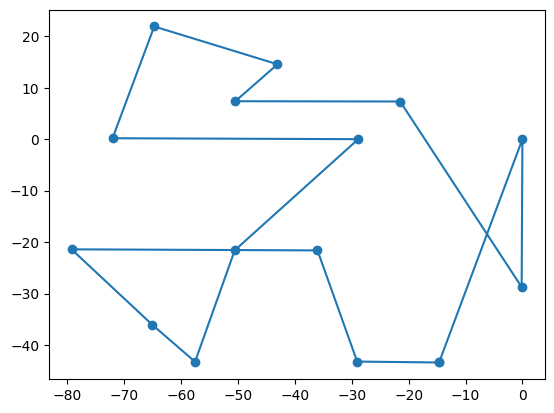

49. generation --> cost --> 409.298126440949


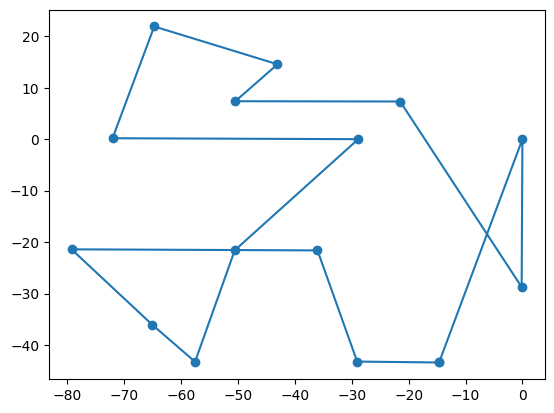

50. generation --> cost --> 409.298126440949


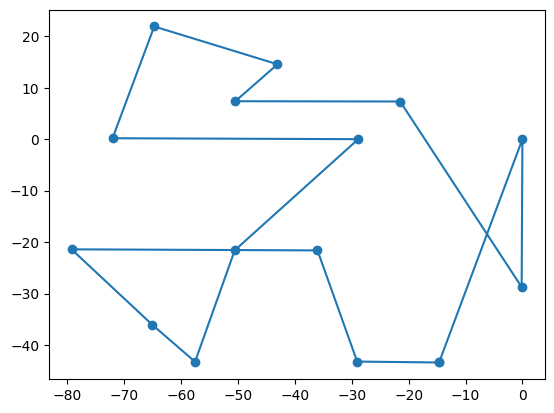

51. generation --> cost --> 409.298126440949


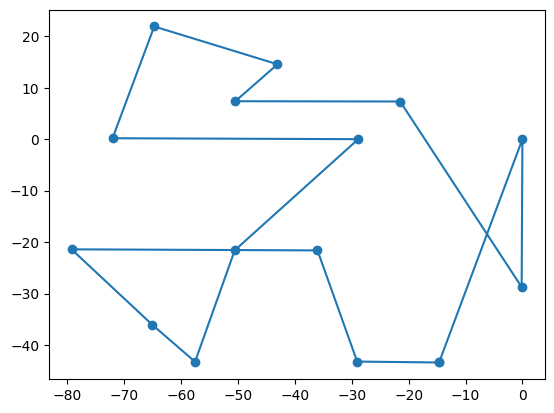

52. generation --> cost --> 409.298126440949


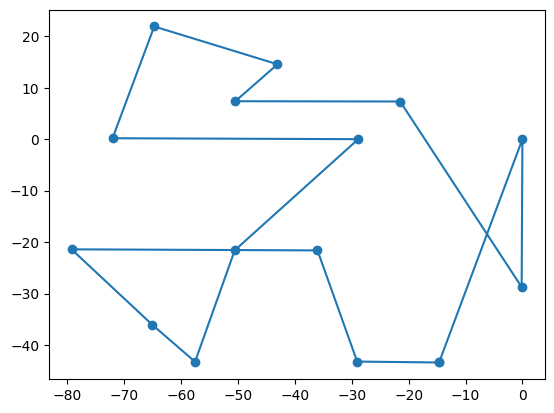

53. generation --> cost --> 409.298126440949


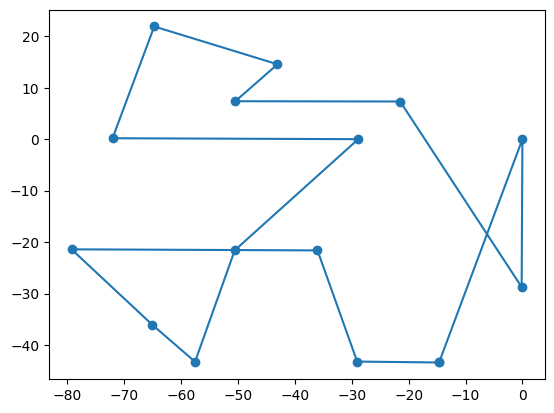

54. generation --> cost --> 409.298126440949


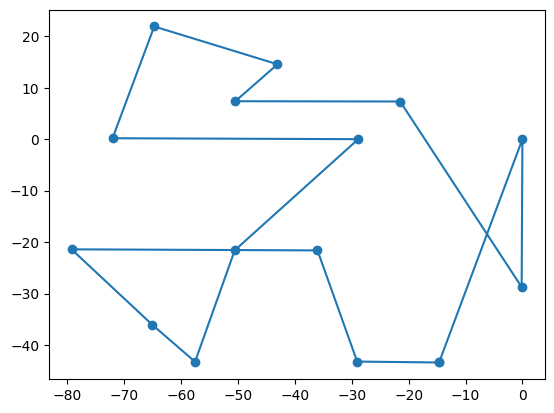

55. generation --> cost --> 409.298126440949


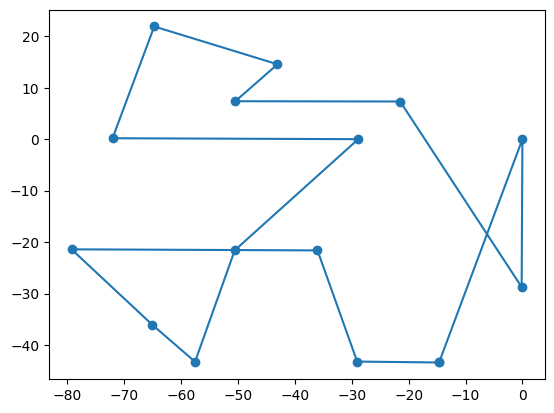

56. generation --> cost --> 398.8696977287224


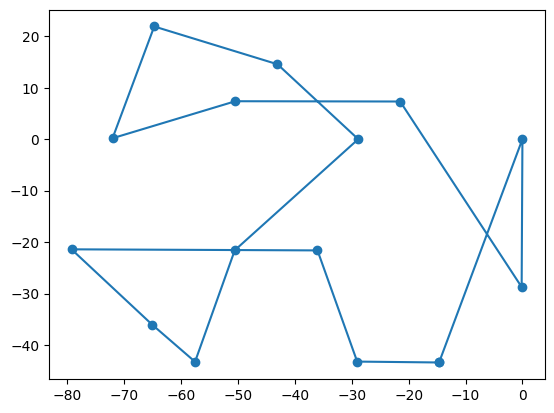

57. generation --> cost --> 389.0506176506184


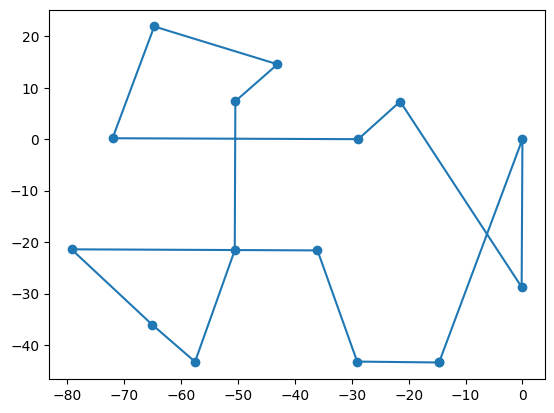

58. generation --> cost --> 434.84914994061637


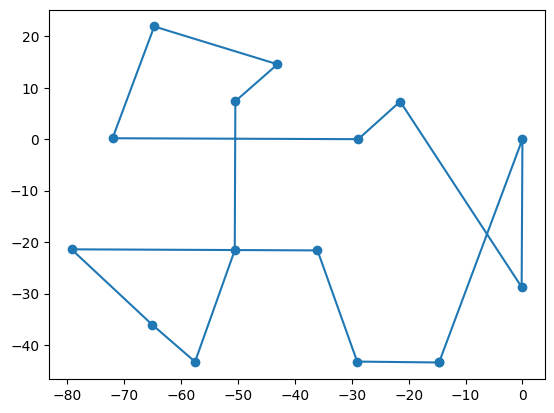

59. generation --> cost --> 389.0506176506184


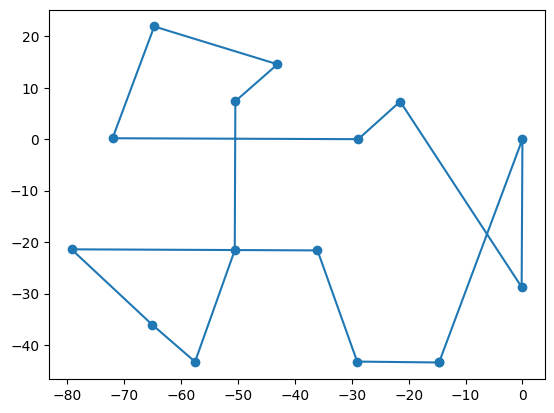

60. generation --> cost --> 389.0506176506184


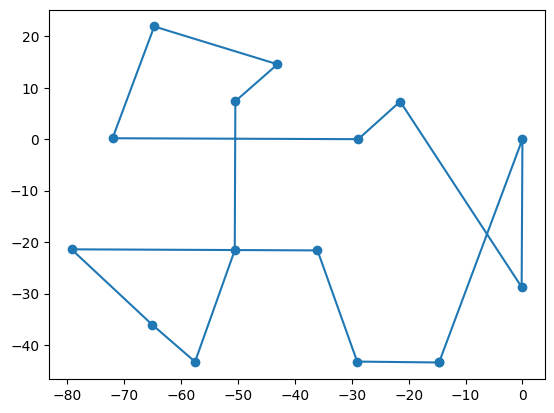

61. generation --> cost --> 389.0506176506184


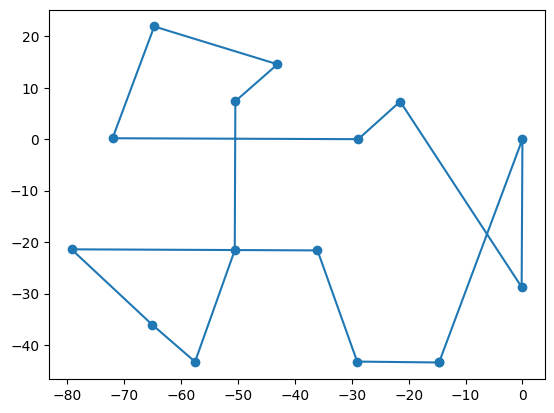

62. generation --> cost --> 389.0506176506184


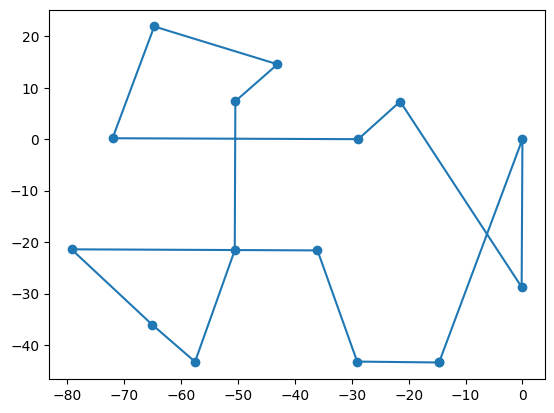

63. generation --> cost --> 389.0506176506184


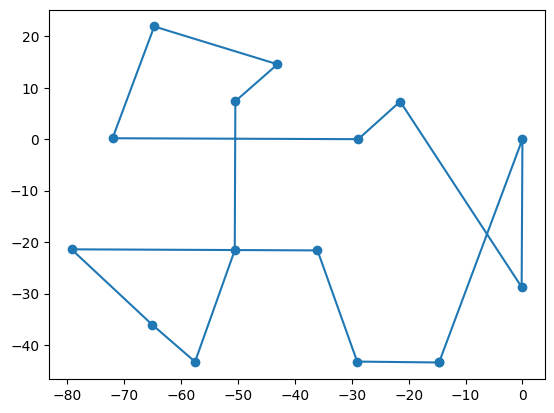

64. generation --> cost --> 389.0506176506184


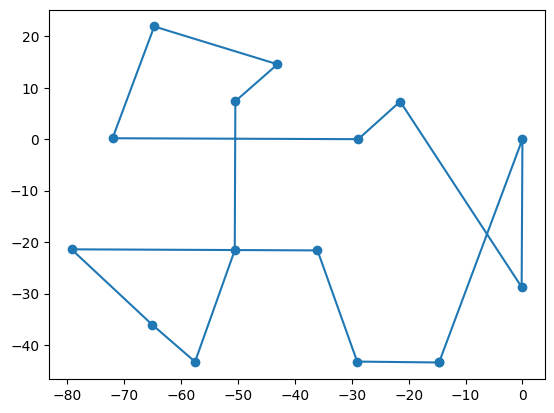

65. generation --> cost --> 389.0506176506184


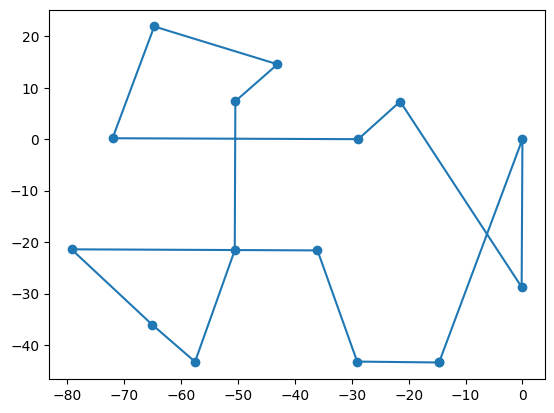

66. generation --> cost --> 389.0506176506184


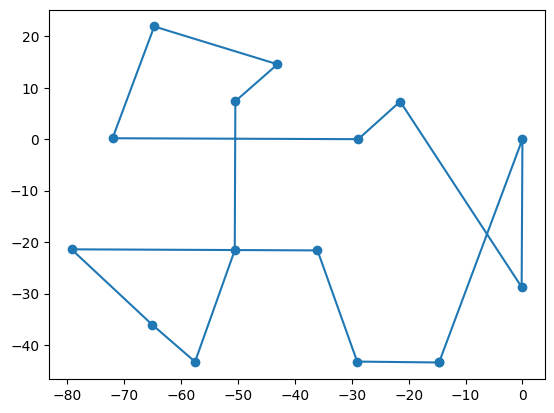

67. generation --> cost --> 389.0506176506184


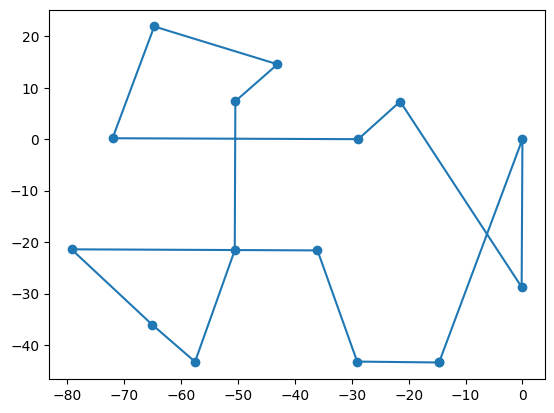

68. generation --> cost --> 389.0506176506184


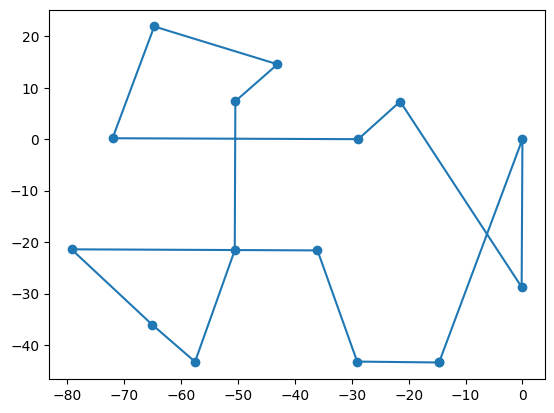

69. generation --> cost --> 389.0506176506184


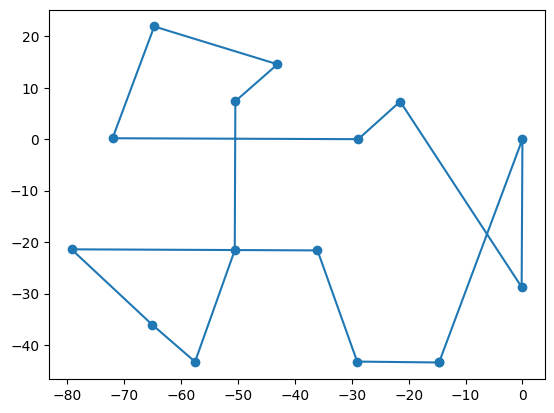

70. generation --> cost --> 389.0506176506184


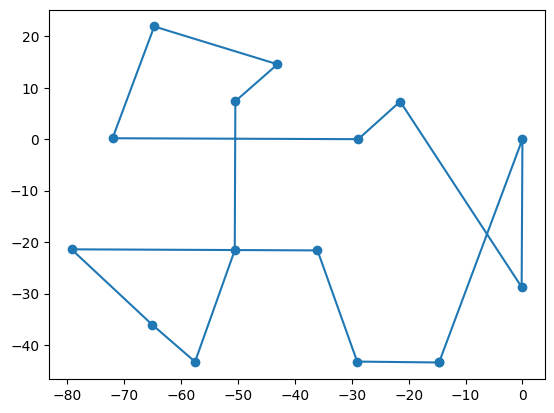

71. generation --> cost --> 380.227549633046


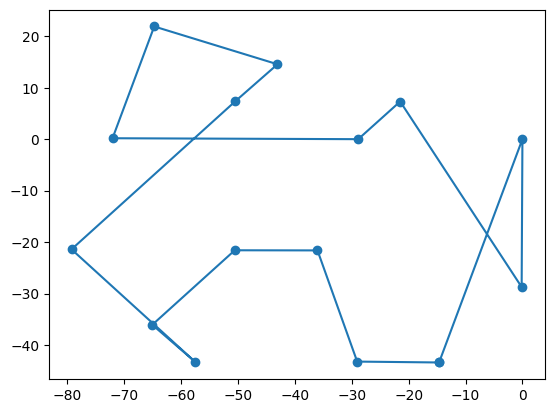

72. generation --> cost --> 380.227549633046


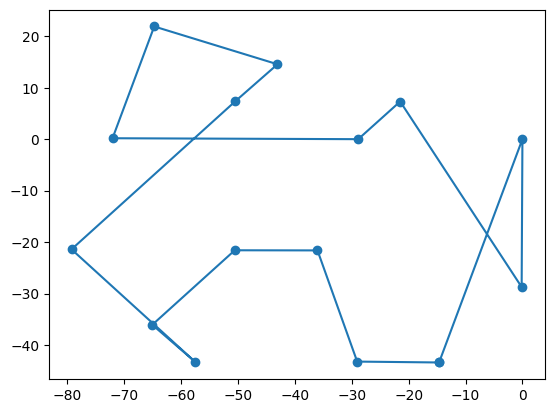

73. generation --> cost --> 380.227549633046


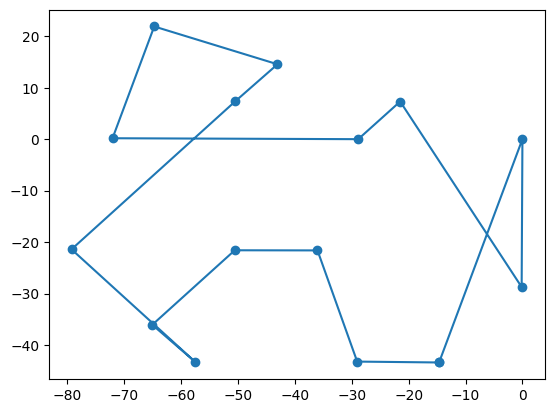

74. generation --> cost --> 380.227549633046


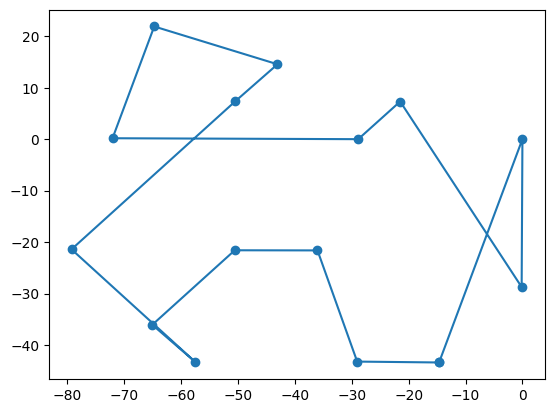

75. generation --> cost --> 380.227549633046


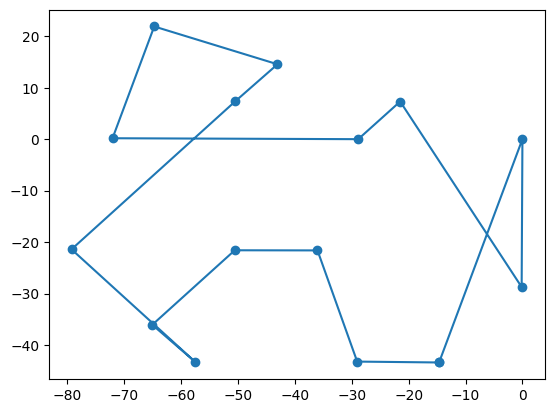

76. generation --> cost --> 380.227549633046


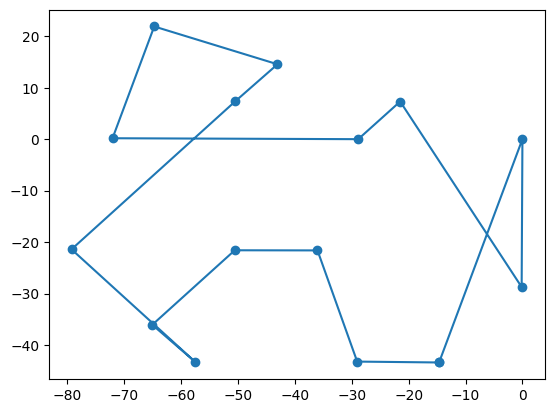

77. generation --> cost --> 335.8712628789656


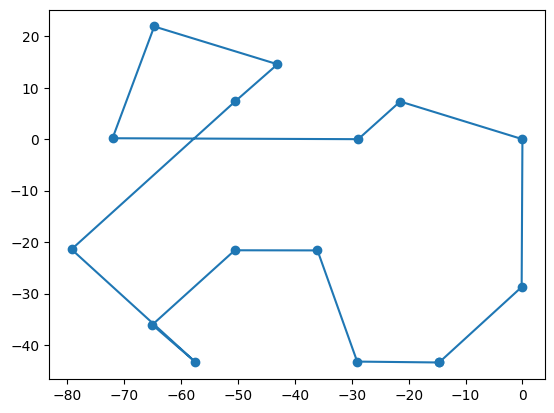

78. generation --> cost --> 335.8712628789656


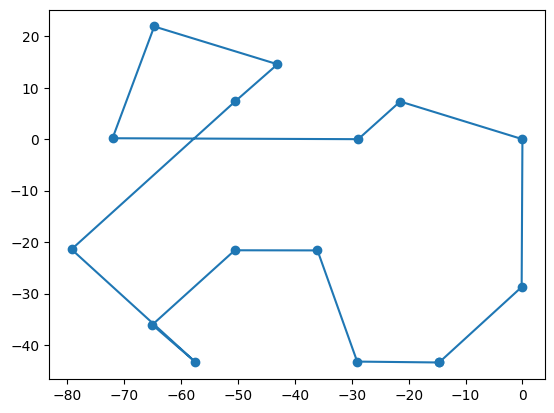

79. generation --> cost --> 335.8712628789656


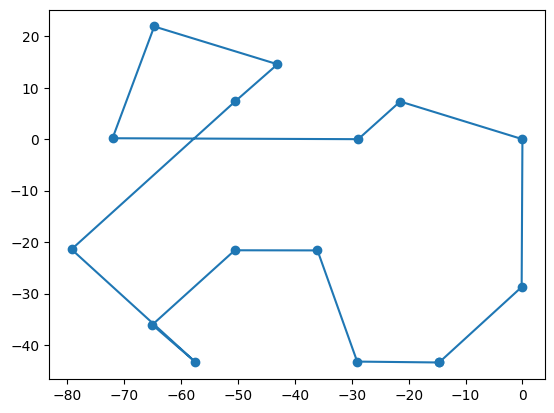

80. generation --> cost --> 335.8712628789656


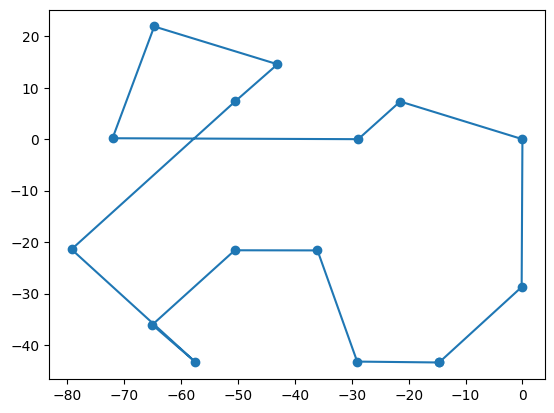

81. generation --> cost --> 335.8712628789656


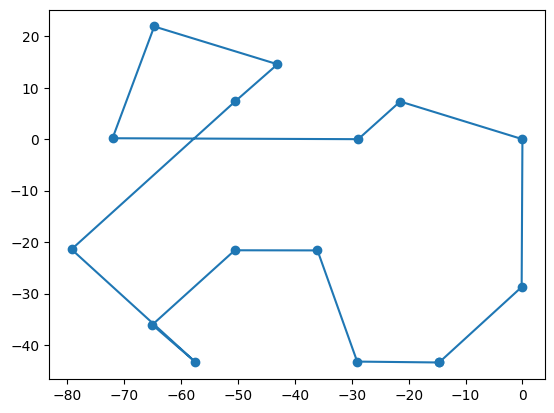

82. generation --> cost --> 335.8712628789656


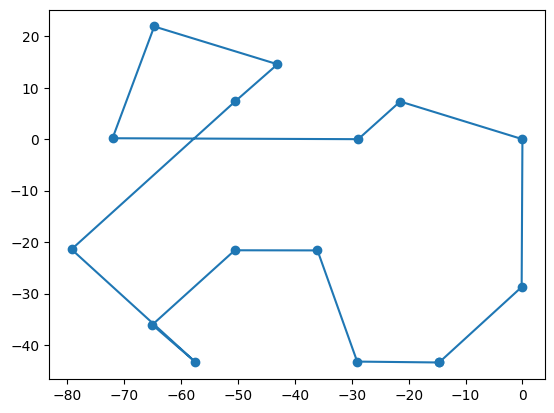

83. generation --> cost --> 335.8712628789656


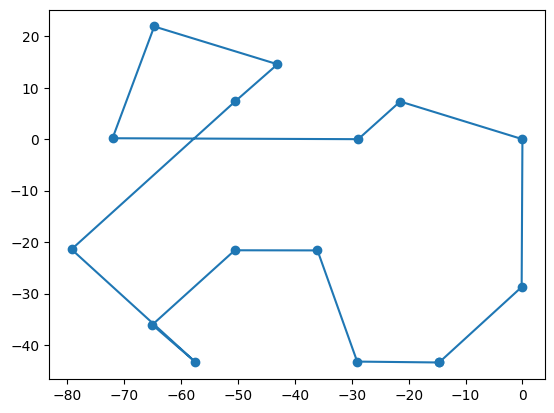

84. generation --> cost --> 335.8712628789656


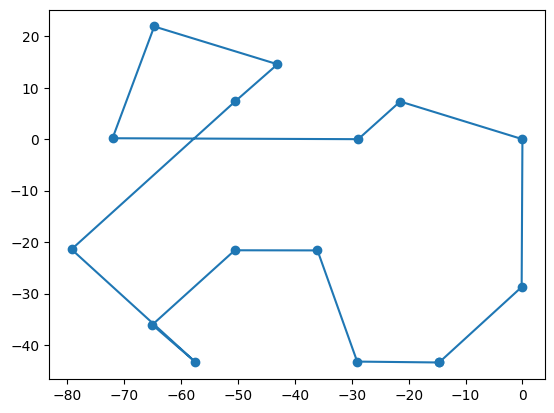

85. generation --> cost --> 317.02709843786545


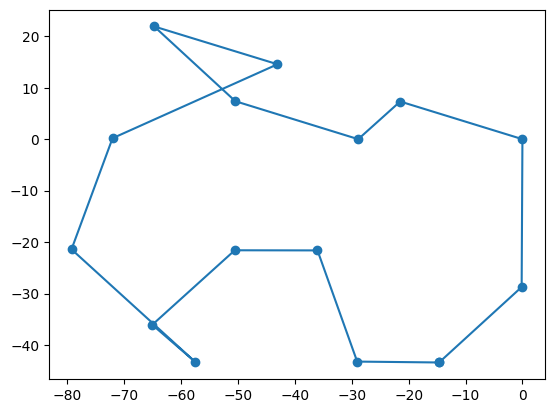

86. generation --> cost --> 335.8712628789656


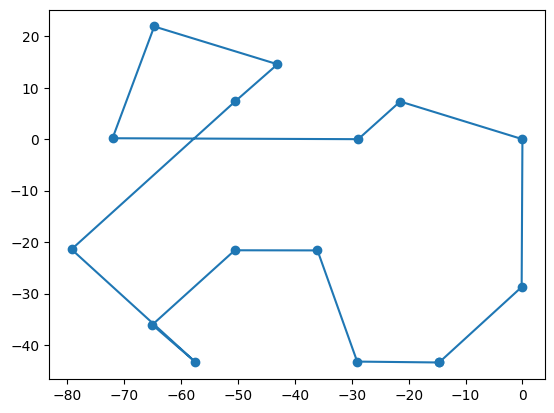

87. generation --> cost --> 337.662248640085


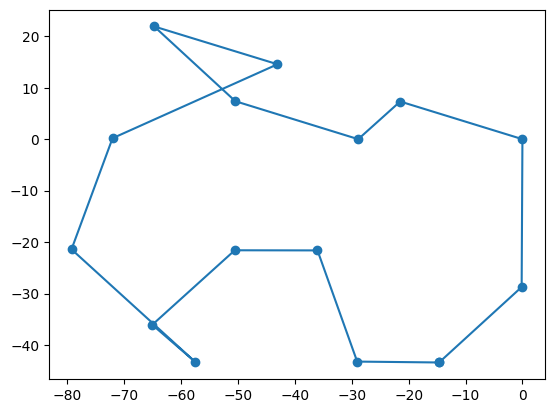

88. generation --> cost --> 358.2973988423046


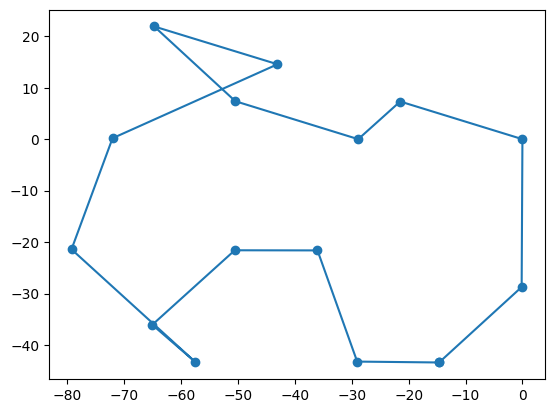

89. generation --> cost --> 317.02709843786545


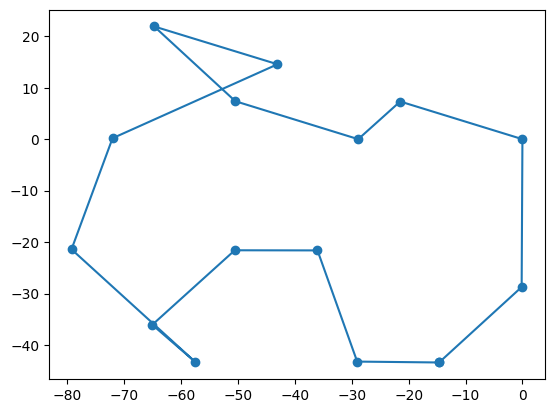

90. generation --> cost --> 304.91765351719886


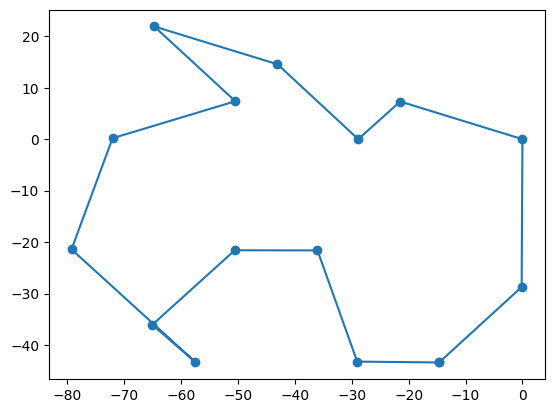

91. generation --> cost --> 304.91765351719886


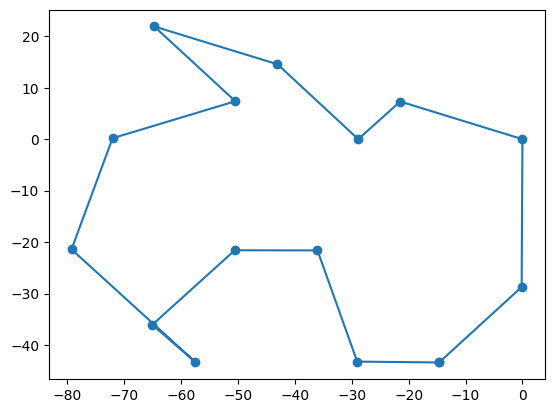

92. generation --> cost --> 304.91765351719886


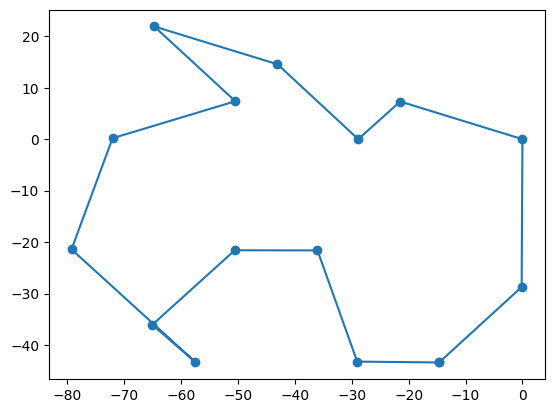

93. generation --> cost --> 304.91765351719886


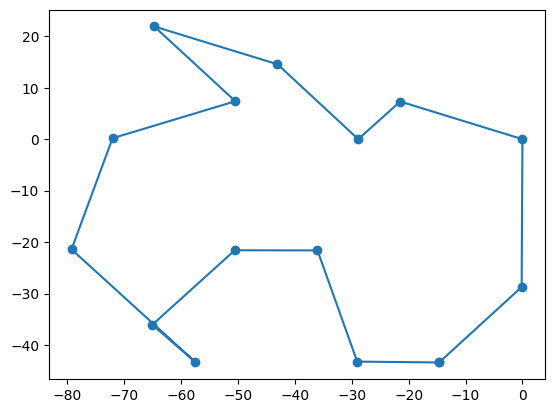

94. generation --> cost --> 304.91765351719886


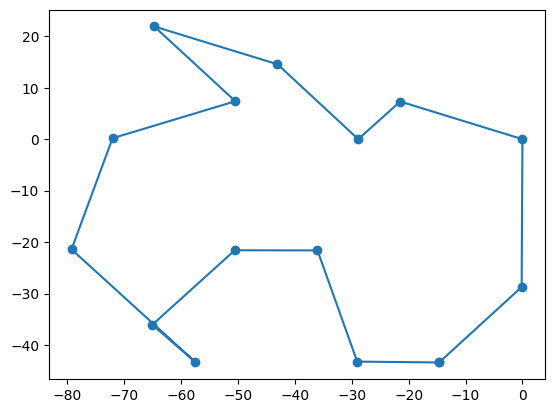

95. generation --> cost --> 304.91765351719886


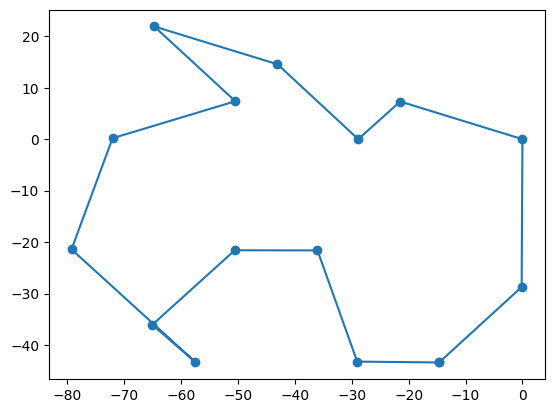

96. generation --> cost --> 304.91765351719886


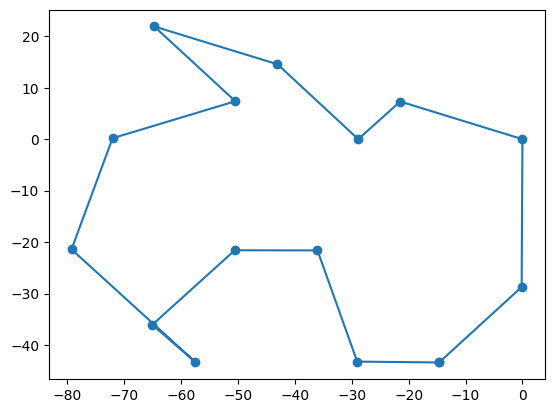

97. generation --> cost --> 325.5528037194184


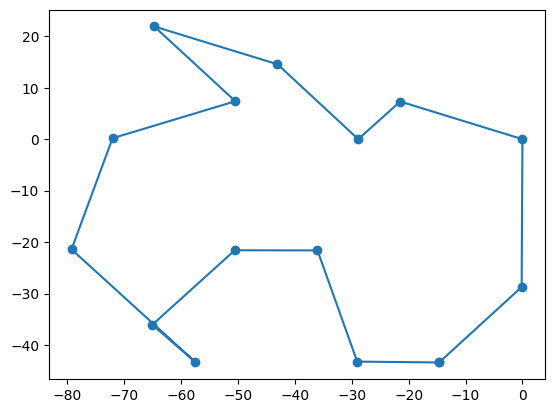

98. generation --> cost --> 304.91765351719886


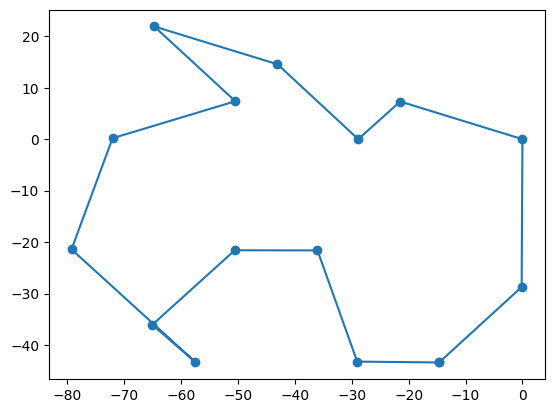

99. generation --> cost --> 304.91765351719886


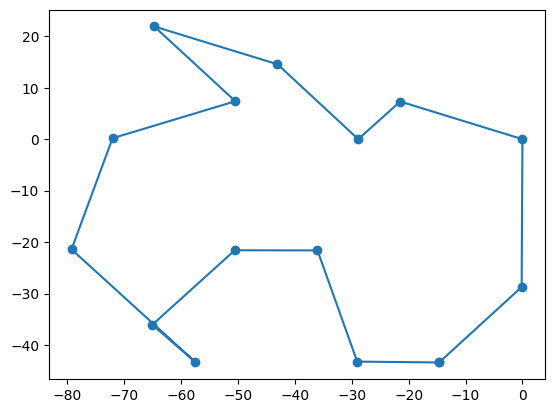

100. generation --> cost --> 304.91765351719886


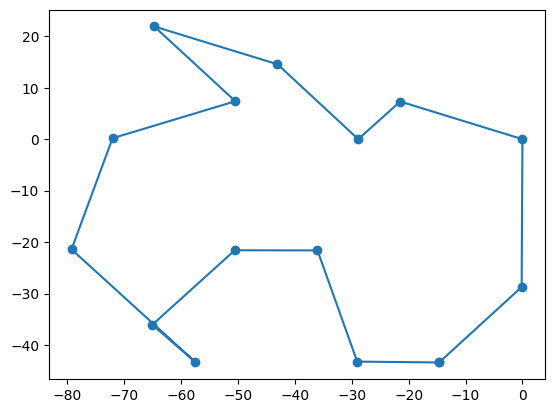

101. generation --> cost --> 304.91765351719886


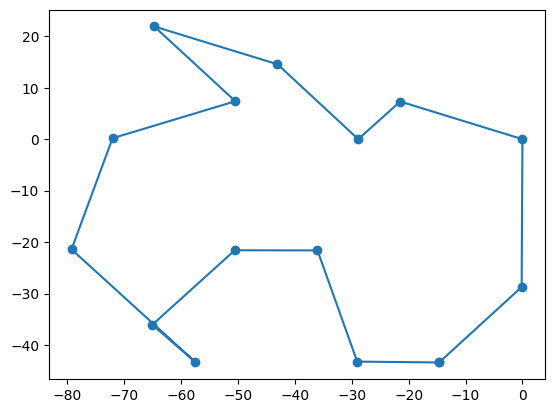

102. generation --> cost --> 304.91765351719886


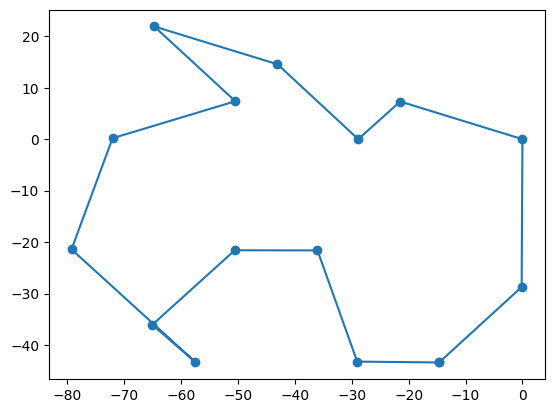

103. generation --> cost --> 304.91765351719886


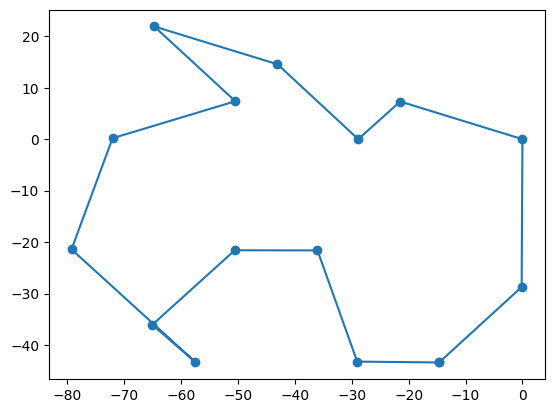

104. generation --> cost --> 304.91765351719886


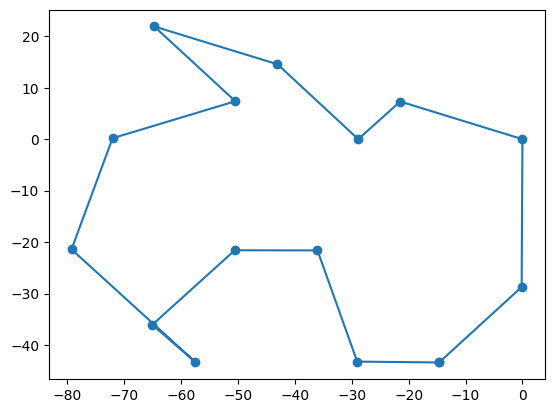

105. generation --> cost --> 304.91765351719886


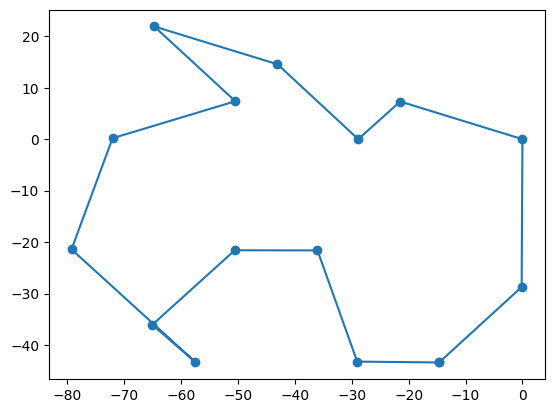

106. generation --> cost --> 304.91765351719886


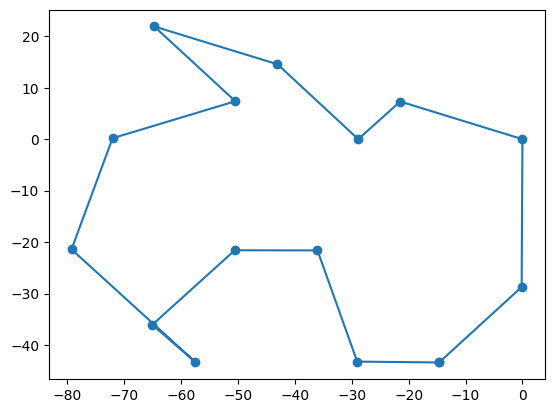

107. generation --> cost --> 304.91765351719886


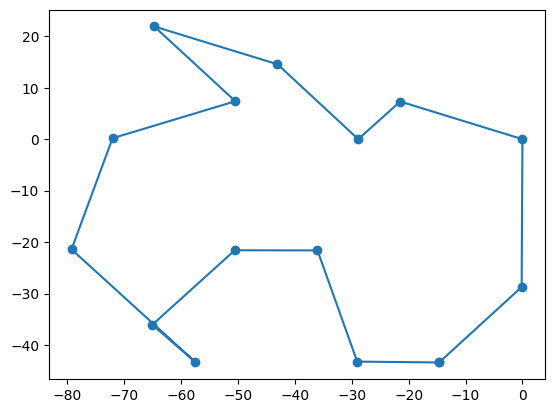

108. generation --> cost --> 304.91765351719886


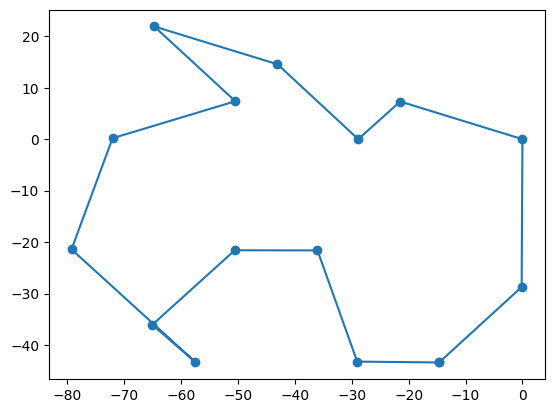

109. generation --> cost --> 304.91765351719886


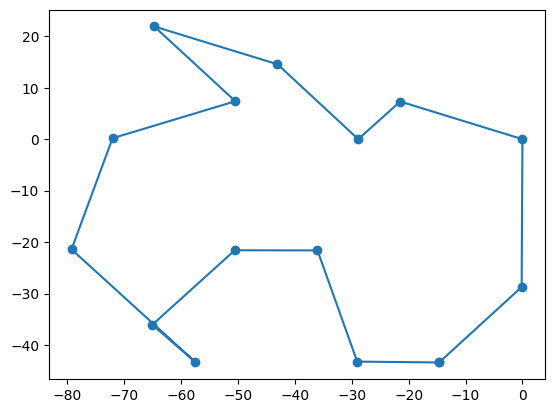

110. generation --> cost --> 304.91765351719886


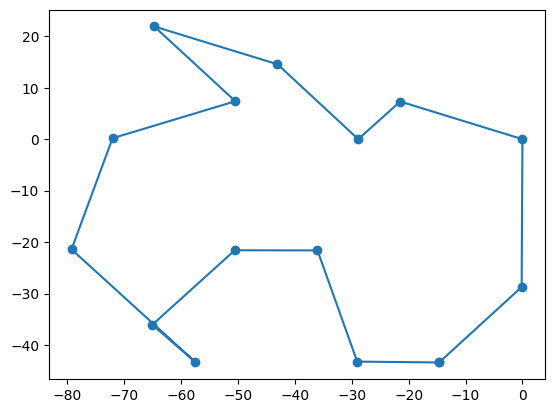

111. generation --> cost --> 304.91765351719886


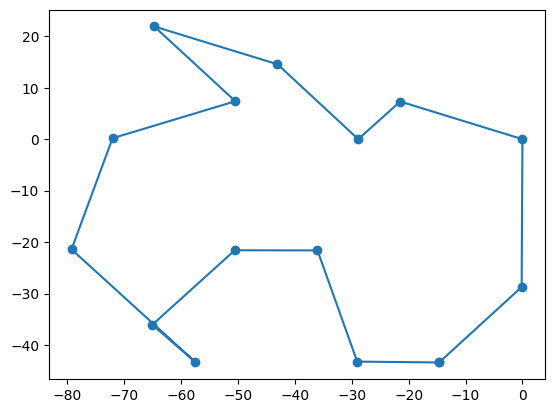

112. generation --> cost --> 304.91765351719886


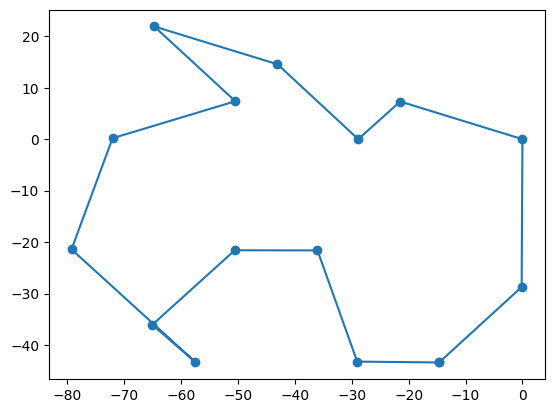

113. generation --> cost --> 304.91765351719886


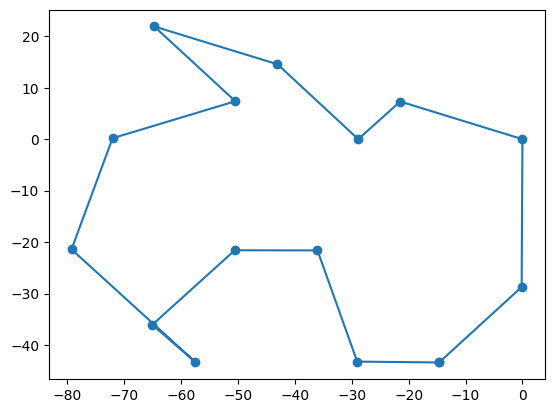

114. generation --> cost --> 304.91765351719886


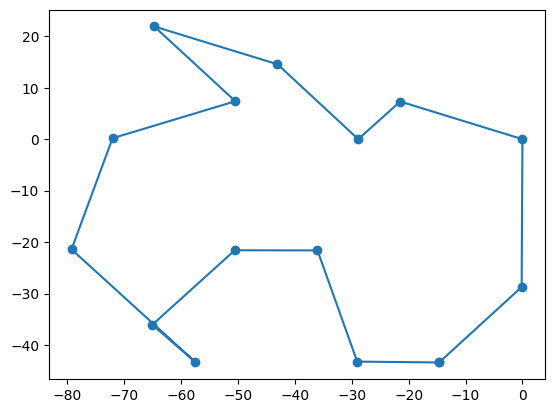

115. generation --> cost --> 325.5528037194184


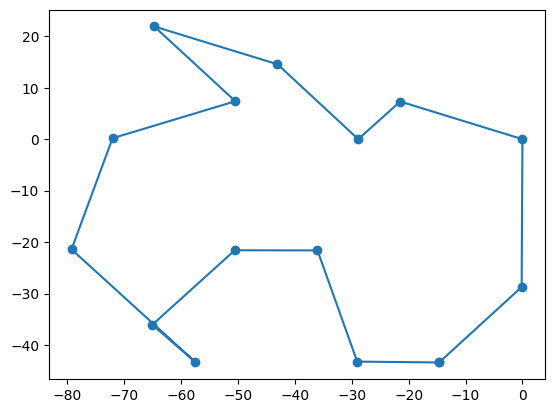

116. generation --> cost --> 304.91765351719886


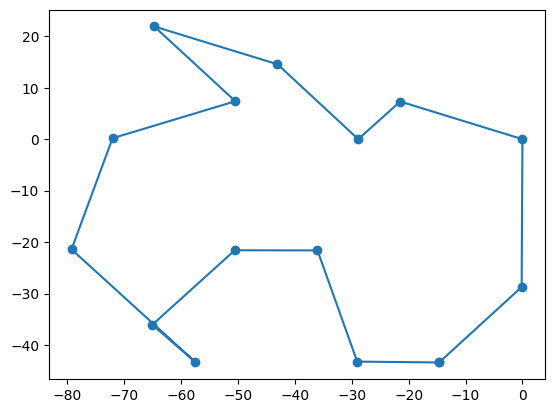

117. generation --> cost --> 304.91765351719886


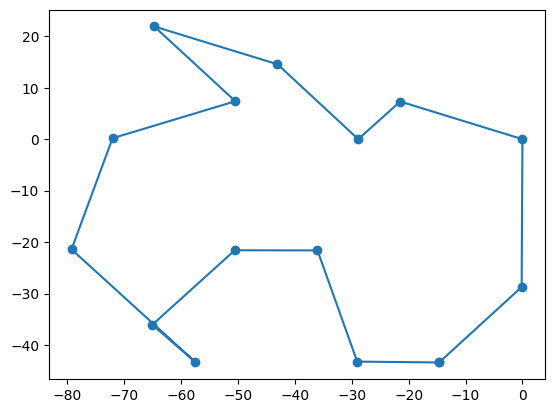

118. generation --> cost --> 304.91765351719886


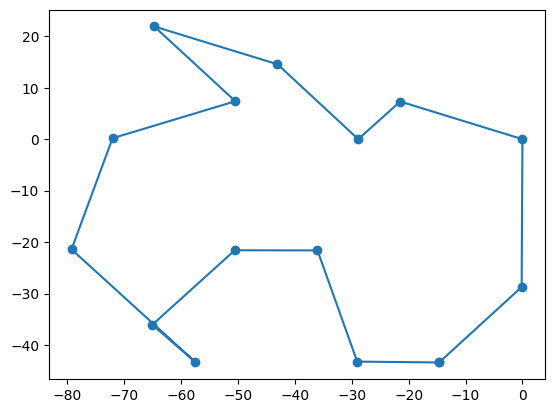

119. generation --> cost --> 304.91765351719886


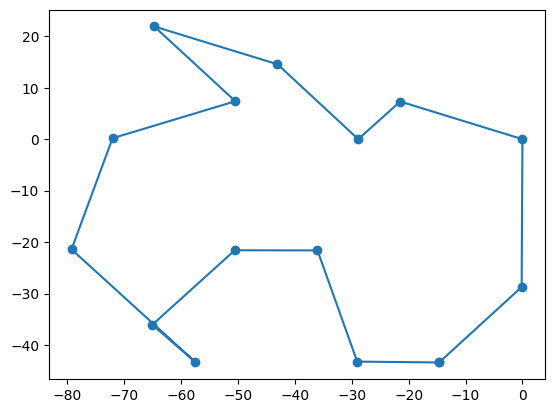

120. generation --> cost --> 304.91765351719886


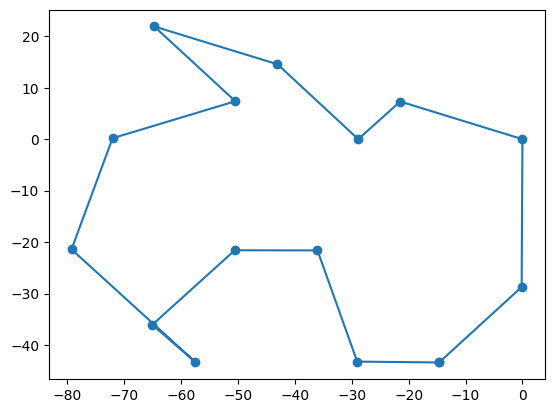

121. generation --> cost --> 304.91765351719886


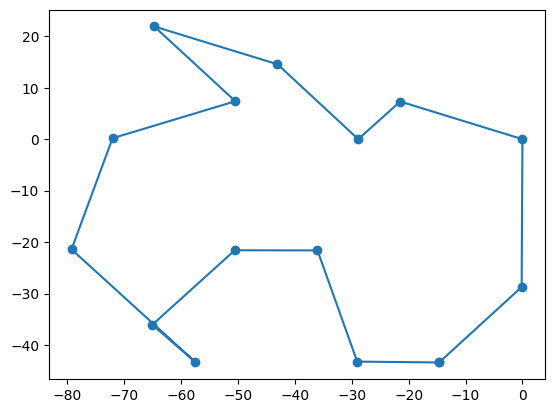

122. generation --> cost --> 304.91765351719886


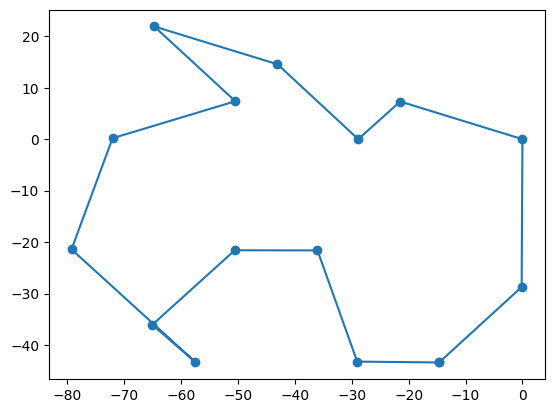

123. generation --> cost --> 304.91765351719886


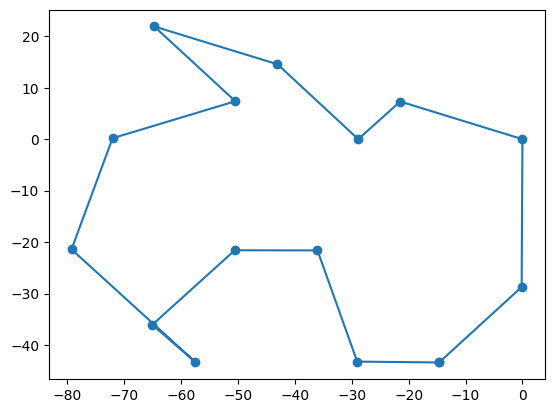

124. generation --> cost --> 304.91765351719886


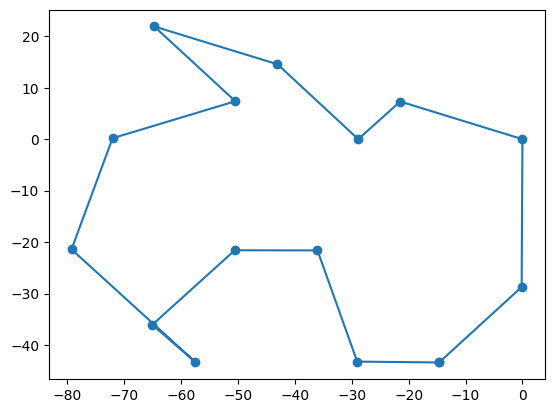

125. generation --> cost --> 304.91765351719886


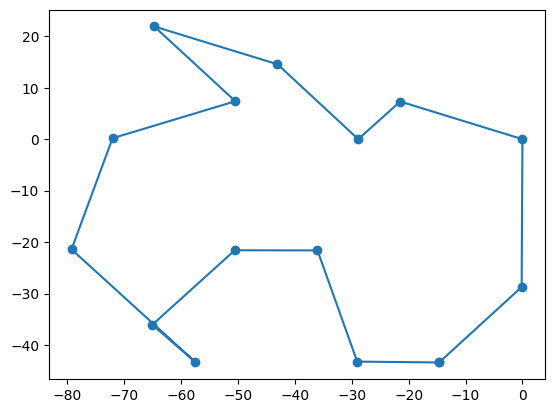

126. generation --> cost --> 304.91765351719886


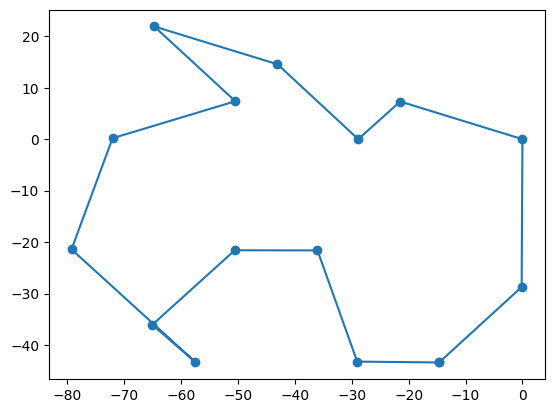

127. generation --> cost --> 304.91765351719886


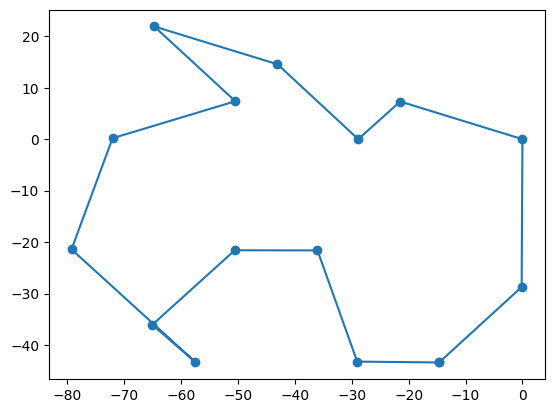

128. generation --> cost --> 304.91765351719886


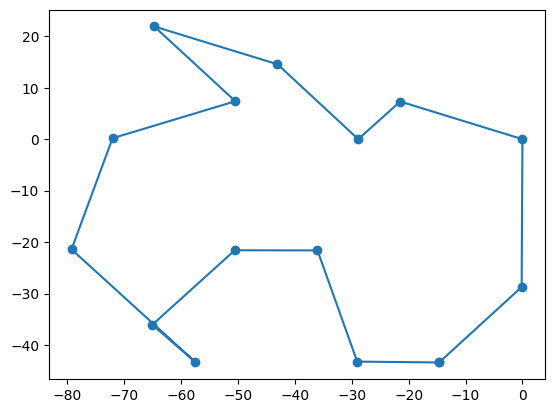

129. generation --> cost --> 304.91765351719886


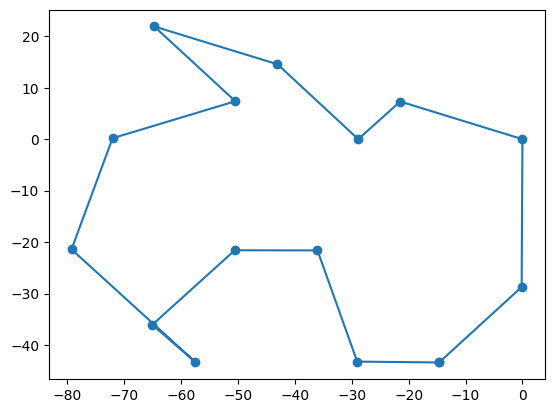

130. generation --> cost --> 304.91765351719886


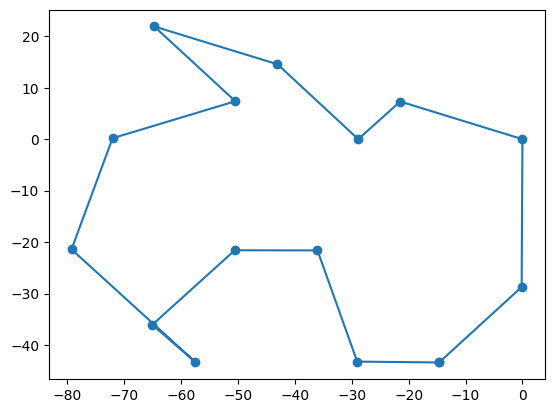

131. generation --> cost --> 304.91765351719886


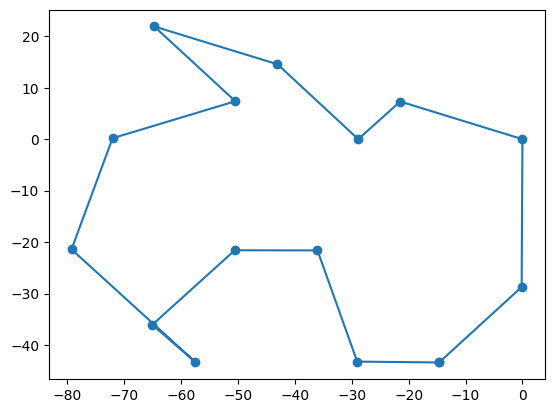

132. generation --> cost --> 304.91765351719886


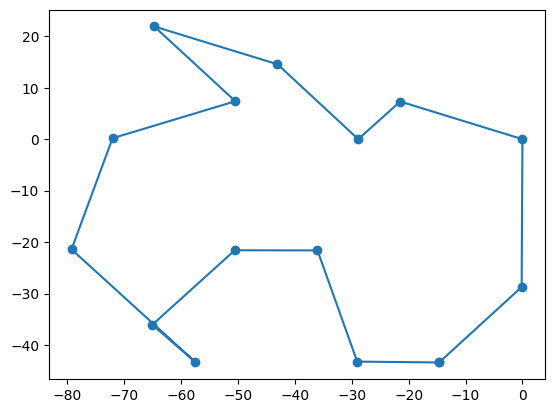

133. generation --> cost --> 296.79294716634564


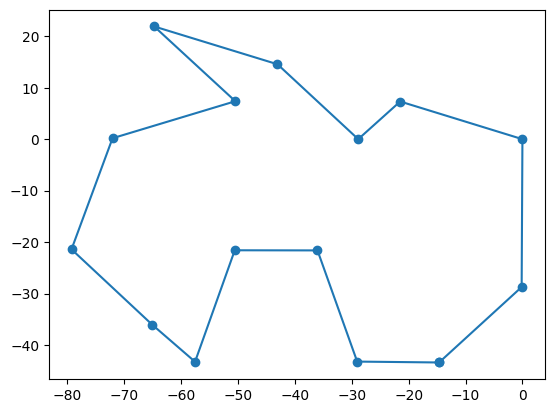

134. generation --> cost --> 296.79294716634564


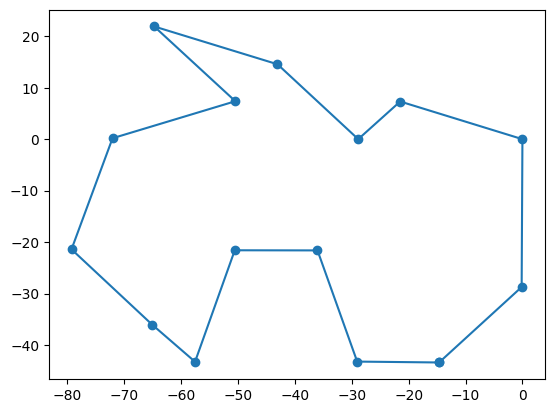

135. generation --> cost --> 296.79294716634564


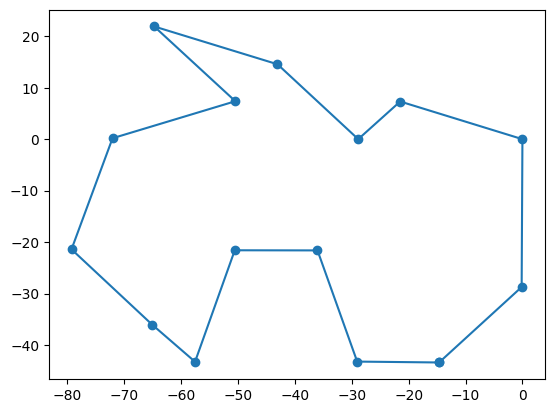

136. generation --> cost --> 296.79294716634564


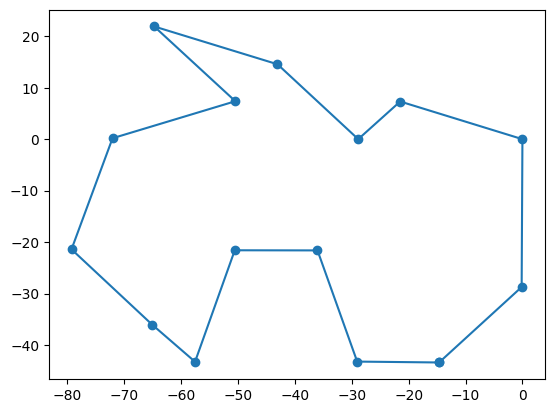

137. generation --> cost --> 296.79294716634564


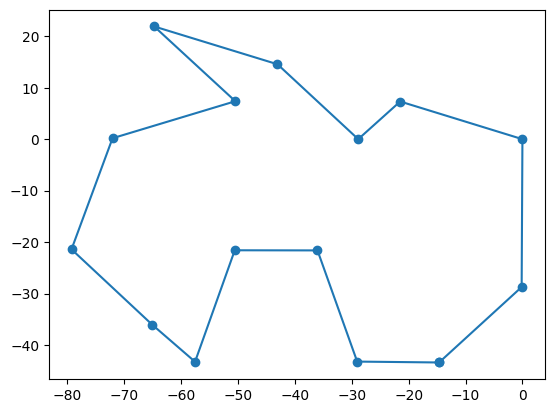

138. generation --> cost --> 296.79294716634564


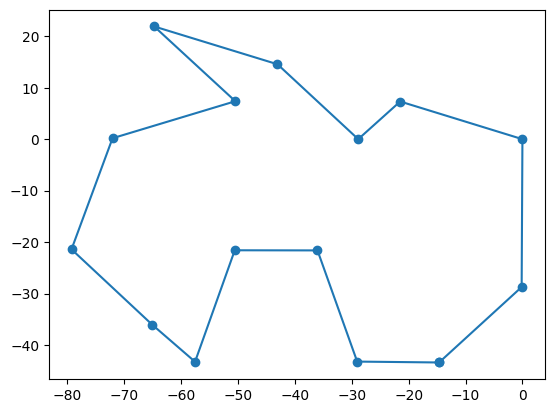

139. generation --> cost --> 296.79294716634564


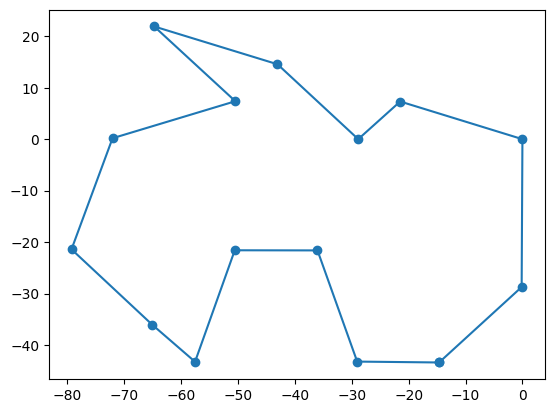

140. generation --> cost --> 296.79294716634564


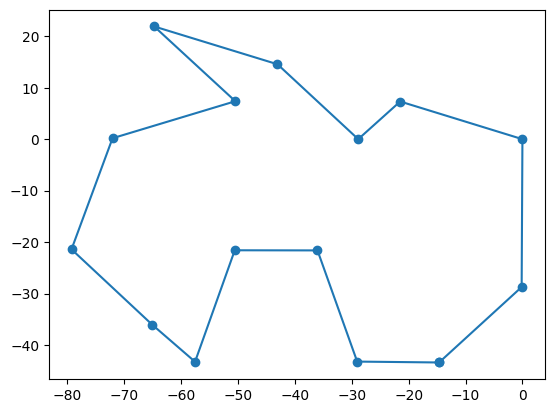

141. generation --> cost --> 296.79294716634564


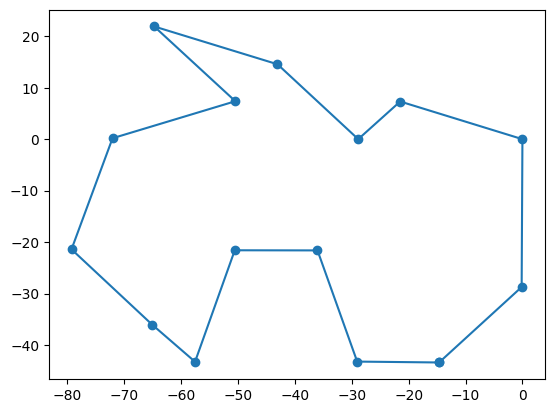

142. generation --> cost --> 296.79294716634564


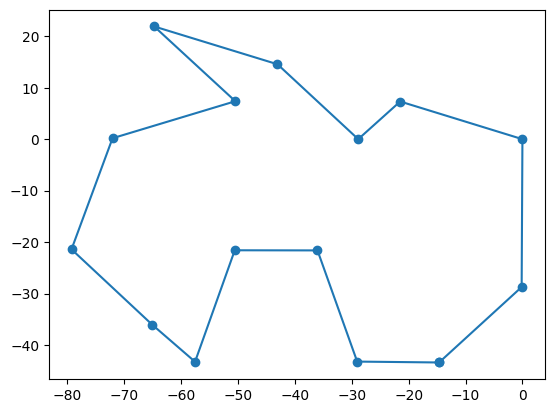

143. generation --> cost --> 296.79294716634564


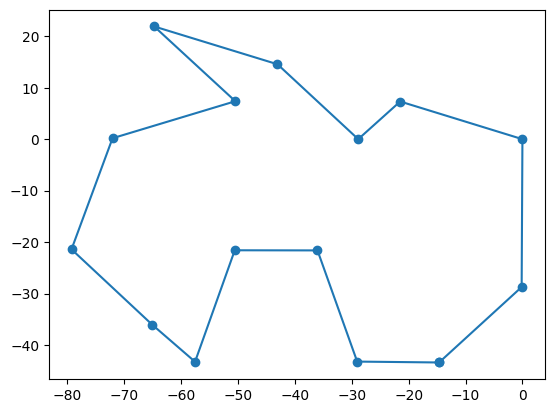

144. generation --> cost --> 296.79294716634564


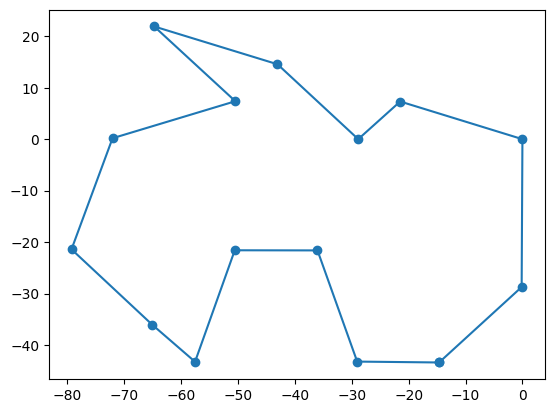

145. generation --> cost --> 296.79294716634564


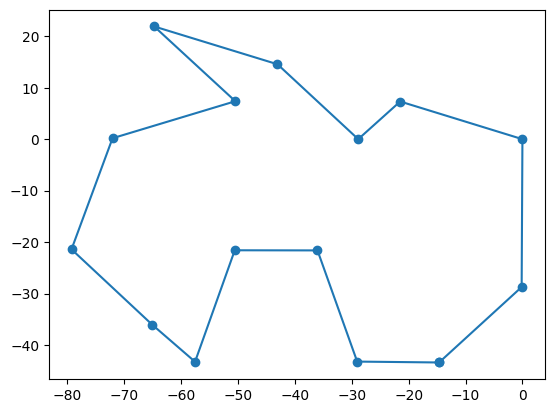

146. generation --> cost --> 296.79294716634564


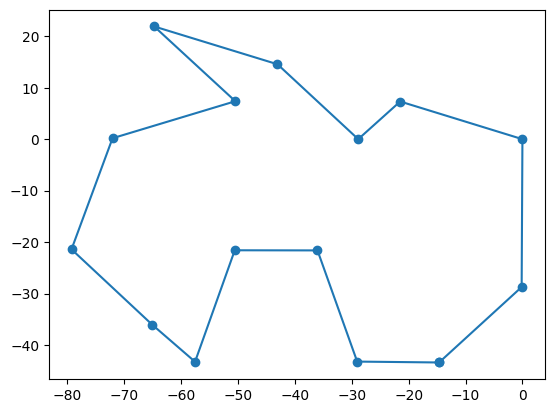

147. generation --> cost --> 296.79294716634564


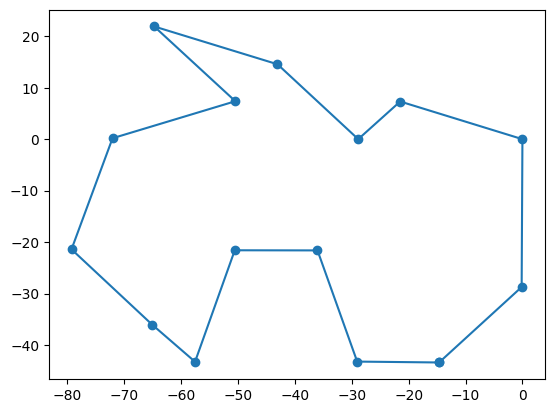

148. generation --> cost --> 296.79294716634564


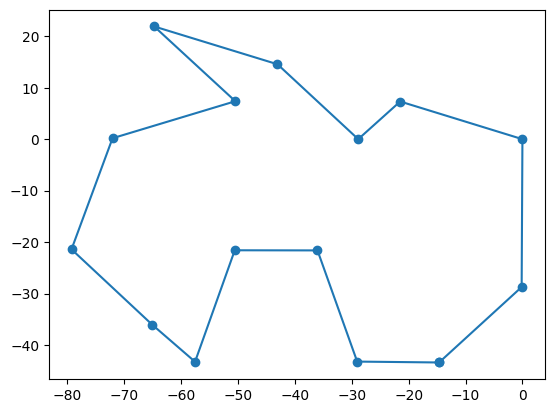

149. generation --> cost --> 296.79294716634564


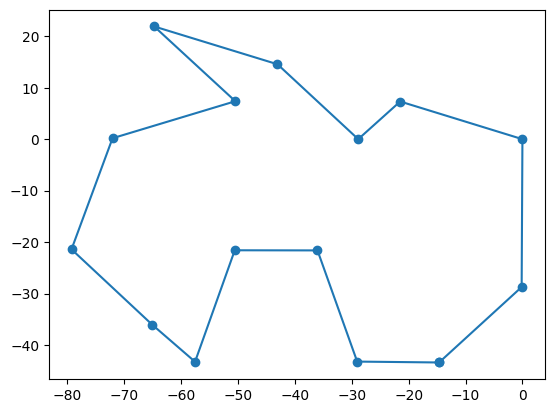

In [1226]:
last_generation, costs_for_plot = genetic_algorithm(population_size, generations_count,elitism_percentage,crossover_probability,mutation_probability)

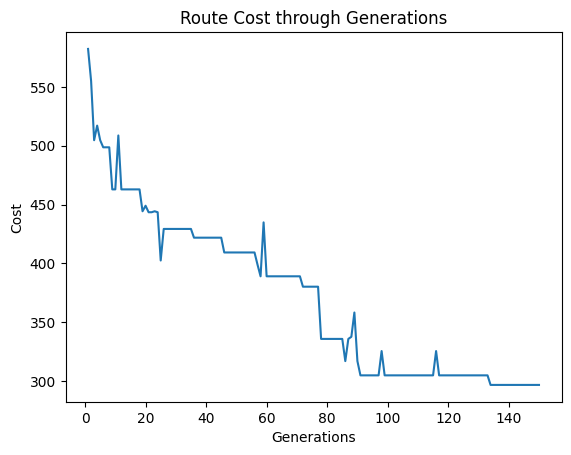

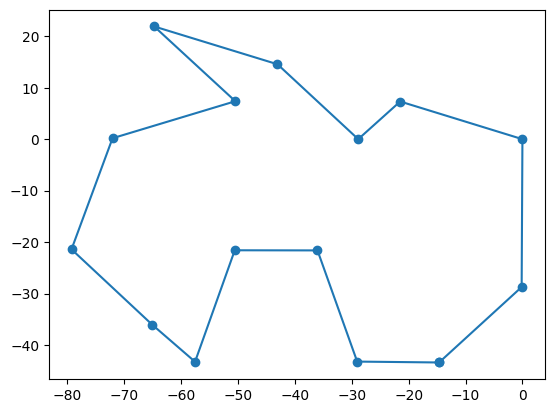

Cost of the best solution:  276.1577969641261


In [1228]:
# Plot the cost through generations
draw_cost_generation(costs_for_plot)

# Select the best solution from the last generation
best_solution = selection(last_generation,candidates_num=4)

# Plot the path of the best solution
draw_path(best_solution)

# Plot the cost of the best solution
print("Cost of the best solution: ",best_solution.cost)